# Select best hyperparameters using KFS-CV and investigate its performance
- SCAN the hyperparameters: and select the best ones
- Note the best hyp and the corresponding performance estimation
- Calculate the performance of the ensemble model
- Calculate the interpolation behavior of the ensembel model

# Load the libraries

In [1]:
import os
import time
import datetime

import numpy as np
print("numpy: ",np.__version__)
import pandas as pd
print("pandas: ",pd.__version__)

import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
print("matplotlib: ",mpl.__version__)

import sklearn

## models
from sklearn.linear_model import Lasso                                     ## LASSO
from sklearn.kernel_ridge import KernelRidge                               ## kernel ridge regression
from sklearn.gaussian_process import GaussianProcessRegressor              ## GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

## metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

rng = np.random.default_rng()

## data splits
# from sklearn.cross_validation import Bootstrap -- deprecated
# from sklearn import cross_validation -- deprecated
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## misc
from sklearn.preprocessing import MinMaxScaler
print("sklearn: ",sklearn.__version__)

import pickle
import joblib
rand = 1   ## set the random number seed for any shuffle/mixing process

numpy:  1.20.3
pandas:  1.3.4
matplotlib:  3.4.3
sklearn:  0.24.2


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 

In [3]:
plt.style.use('../mpl-templates/nikhil1.mplstyle')
import string
label_list = list(string.ascii_lowercase)

In [1]:
## Create directories if they don't exist
if not os.path.isdir('figures'):
    print("Creating figures folder")
    os.makedirs('figures')
    
if not os.path.isdir('best-models'):
    print("Creating best-models folder")
    os.makedirs('best-models')
        
if not os.path.isdir('ensemble-metrics'):
    print("Creating ensemble-metrics folder")
    os.makedirs('ensemble-metrics')

NameError: name 'os' is not defined

# Load the data

In [4]:
## Load the data
datafile = "../data/vlugt-1059points.csv"
vdata_all = pd.read_csv(datafile) 

## Select the box length -- 2000p
vdata_np_list = []
vdata_np_list.append(vdata_all[vdata_all['num_particles']==500].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==1000].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==2000].copy())
vdata_np_list.append(vdata_all[vdata_all['num_particles']==4000].copy())

In [5]:
## Extract features from the dataframe
npdata = vdata_np_list[2][['X_1', 'epsilon_2', 'sigma_2', 'k_12', 'zeta', 'BoxLength', 'Viscosity', 'Viscosity_err',
                            'num_particles']].values
np.random.seed(rand)
np.random.shuffle(npdata)

X_2000p_preMD_raw = npdata[:, :4].copy()
zeta_2000p_raw = npdata[:, 4].copy().reshape((-1,1)).copy()
density_2000p_raw = np.array(npdata[:, 8]/(npdata[:,5]**3)).reshape((-1,1)).copy()
X_2000p_fset1_raw = np.hstack((X_2000p_preMD_raw,zeta_2000p_raw,density_2000p_raw))

Y_fset1_raw = npdata[:, 6].copy()
Yerr_fset1_raw = npdata[:, 7].copy()

print("X shape: ", X_2000p_fset1_raw.shape)
print("Y shape: ", Y_fset1_raw.shape)
print("Yerr shape: ", Yerr_fset1_raw.shape)

X shape:  (273, 6)
Y shape:  (273,)
Yerr shape:  (273,)


In [6]:
## transform the features if necessary
sc_2000p_fset1 = MinMaxScaler() ## Needs a 2D array -- if only a single feature, use reshape
sc_2000p_fset1.fit(X_2000p_fset1_raw) 
X_2000p_fset1_scaled = sc_2000p_fset1.transform(X_2000p_fset1_raw)
print("X scaled : ", X_2000p_fset1_scaled.shape)

X scaled :  (273, 6)


# Interpolation data

## load the data and convert to a dataframe

In [7]:
x1_grid_points = pd.read_csv("../data/x1_int_points_18mar22.csv")
x1_grid_points['BoxLength'] = [19.2295, 22.1713, 14.6200, 18.4201]
x1_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

eps2_grid_points = pd.read_csv("../data/eps2_int_points_18mar22.csv")
eps2_grid_points['BoxLength'] = [21.9797, 21.1303, 20.9318, 20.0900]
eps2_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

sig2_grid_points = pd.read_csv("../data/sig2_int_points_18mar22.csv")
sig2_grid_points['BoxLength'] = [22.3893, 18.0137, 15.3401, 16.4214]
sig2_grid_points['num_particles'] = [2000, 2000, 2000, 2000]

k12_grid_points = pd.read_csv("../data/k12_int_points_18mar22.csv")
k12_grid_points['BoxLength'] = [23.5442, 13.1799, 19.0972, 16.3606, 21.2325]
k12_grid_points['num_particles'] = [2000, 2000, 2000, 2000, 2000]

## preMD: extract to numpy arrays

In [8]:
interp_df = pd.concat([x1_grid_points, eps2_grid_points, sig2_grid_points, k12_grid_points], ignore_index=True)
interp_data = interp_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'BoxLength', 'num_particles', 'eta_md', 'eta_md_err']].values

X_interp_preMD_raw = interp_data[:, :4].copy()
Y_interp_raw = interp_data[:, 6].copy()
Yerr_interp_raw = interp_data[:, 7].copy()
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_raw/Y_interp_raw)))

interp MAPE: 2.26


### use the same transform as the train data

In [9]:
## transform the features if necessary
# X_interp_preMD_scaled = sc_alldata_preMD.transform(X_interp_preMD_raw)
# print("X interp scaled : ", X_interp_preMD_scaled.shape)

## fset1: extract to numpy arrays

In [10]:
interp_df = pd.concat([x1_grid_points, eps2_grid_points, sig2_grid_points, k12_grid_points], ignore_index=True)
interp_data = interp_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'BoxLength', 'num_particles', 'eta_md', 'eta_md_err']].values

zeta_interp_raw = (interp_data[:,5]*np.pi/(6.0*interp_data[:,4]**3))*\
                  (interp_data[:,0]*1.0**3 + (1-interp_data[:,0])*interp_data[:,2]**3)
zeta_interp_raw = zeta_interp_raw.reshape((-1,1))
density_interp_raw = np.array(interp_data[:,5]/interp_data[:,4]**3).reshape((-1,1))

X_interp_fset1_raw = np.hstack((X_interp_preMD_raw,zeta_interp_raw,density_interp_raw))
Y_interp_raw = interp_data[:, 6].copy()
Yerr_interp_raw = interp_data[:, 7].copy()

In [11]:
X_interp_fset1_scaled = sc_2000p_fset1.transform(X_interp_fset1_raw)
print("X interp scaled : ", X_interp_fset1_scaled.shape)

X interp scaled :  (17, 6)


In [12]:
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_raw/Y_interp_raw)))

interp MAPE: 2.26


# Helper classes and data creation

## Data classes

### data class for Kfold+split model selection and performance evaluation (mspe) -- kfold_split_mspe_data()

In [13]:
## Add a list to store the data to be fitted by the best hyperparameter in each split
class kfold_split_mspe_data:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0
        self.num_train_pts = 0
        self.num_val_pts = 0
        self.num_test_pts = 0
        self.num_interp_pts = 0
        self.num_fit_pts = 0
        
        ## Lists to store the data
        self.X_train_dbllist = [] ; self.Y_train_dbllist = [] ; self.Yerr_train_dbllist = []
        self.X_val_dbllist = [] ; self.Y_val_dbllist = [] ; self.Yerr_val_dbllist = []
        self.X_test_list = [] ; self.Y_test_list = [] ; self.Yerr_test_list = []
        self.X_interp_list = [] ; self.Y_interp_list = [] ; self.Yerr_interp_list = []
        self.X_fit_list = [] ; self.Y_fit_list = [] ; self.Yerr_fit_list = []
        

## Create Kfol+shuffle split data 

### 5fold CV -- kfs_mspe_data_t1

In [14]:
# 
num_kfs_cycles_t1 = 20 ; num_kfs_folds_t1 = 5 ;
num_data_pts = X_2000p_fset1_raw.shape[0]

# Initialize the RNG
rng_kfs_t1 = np.random.default_rng(seed=1245)
rand_kfs_seed_t1 = rng_kfs_t1.integers(1,100000,size=num_kfs_cycles_t1)

# Create the data object
kfs_mspe_data_t1 = kfold_split_mspe_data()
kfs_mspe_data_t1.num_splits = num_kfs_cycles_t1
kfs_mspe_data_t1.num_folds = num_kfs_folds_t1

# create shuffle split train-val-test samples from the whole dataset
for j in range(num_kfs_cycles_t1):
    X_kfs_train_t1, X_kfs_test_t1, \
    Y_kfs_train_t1, Y_kfs_test_t1, \
    Yerr_kfs_train_t1, Yerr_kfs_test_t1 = train_test_split(X_2000p_fset1_scaled, Y_fset1_raw, Yerr_fset1_raw,
                                         test_size = 0.20, random_state=rand_kfs_seed_t1[j])
    
    X_kfs_fit_t1  = []  ; X_kfs_val_t1 = []
    Y_kfs_fit_t1 = []   ; Y_kfs_val_t1 = []
    Yerr_kfs_fit_t1 = []; Yerr_kfs_val_t1 = []

    ## Prepare the 5-fold splits
    kf = KFold(num_kfs_folds_t1, shuffle=True, random_state=2*rand_kfs_seed_t1[j])

    # kf.split iterates over n_splits
    for train_ndx, val_ndx in kf.split(X_kfs_train_t1):
        X_kfs_fit_t1 .append(X_kfs_train_t1[train_ndx])
        X_kfs_val_t1.append(X_kfs_train_t1[val_ndx])
        Y_kfs_fit_t1.append(Y_kfs_train_t1[train_ndx])
        Y_kfs_val_t1.append(Y_kfs_train_t1[val_ndx])
        Yerr_kfs_fit_t1.append(Yerr_kfs_train_t1[train_ndx])
        Yerr_kfs_val_t1.append(Yerr_kfs_train_t1[val_ndx])

    kfs_mspe_data_t1.X_train_dbllist.append(X_kfs_fit_t1) ; kfs_mspe_data_t1.Y_train_dbllist.append(Y_kfs_fit_t1) ; kfs_mspe_data_t1.Yerr_train_dbllist.append(Yerr_kfs_fit_t1)
    kfs_mspe_data_t1.X_val_dbllist.append(X_kfs_val_t1) ; kfs_mspe_data_t1.Y_val_dbllist.append(Y_kfs_val_t1) ; kfs_mspe_data_t1.Yerr_val_dbllist.append(Yerr_kfs_val_t1)
    kfs_mspe_data_t1.X_test_list.append(X_kfs_test_t1) ; kfs_mspe_data_t1.Y_test_list.append(Y_kfs_test_t1) ; kfs_mspe_data_t1.Yerr_test_list.append(Yerr_kfs_test_t1)
    kfs_mspe_data_t1.X_interp_list.append(X_interp_fset1_scaled) ; kfs_mspe_data_t1.Y_interp_list.append(Y_interp_raw) ; kfs_mspe_data_t1.Yerr_interp_list.append(Yerr_interp_raw)
    kfs_mspe_data_t1.X_fit_list.append(X_kfs_train_t1) ; kfs_mspe_data_t1.Y_fit_list.append(Y_kfs_train_t1) ; kfs_mspe_data_t1.Yerr_fit_list.append(Yerr_kfs_train_t1)

kfs_mspe_data_t1.num_train_pts = X_kfs_fit_t1[0].shape[0] 
kfs_mspe_data_t1.num_val_pts = X_kfs_val_t1[0].shape[0] 
kfs_mspe_data_t1.num_test_pts = X_kfs_test_t1.shape[0] 
kfs_mspe_data_t1.num_interp_pts = X_interp_fset1_scaled.shape[0] 
kfs_mspe_data_t1.num_fit_pts = kfs_mspe_data_t1.num_train_pts + kfs_mspe_data_t1.num_val_pts

SPLITS:  20
SPLITS:  5
TRAIN:  174
VAL:  44
TEST:  55
INTERP:  17


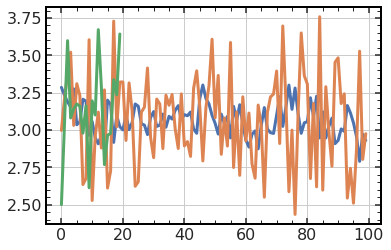

In [15]:
print("SPLITS: ",kfs_mspe_data_t1.num_splits)
print("SPLITS: ",kfs_mspe_data_t1.num_folds)
print("TRAIN: ",kfs_mspe_data_t1.num_train_pts)
print("VAL: ",kfs_mspe_data_t1.num_val_pts)
print("TEST: ",kfs_mspe_data_t1.num_test_pts)
print("INTERP: ",kfs_mspe_data_t1.num_interp_pts)
tmparr = [] ; tmparr2 = [] ; tmparr3 = []
for i in range(kfs_mspe_data_t1.num_splits):
    tmparr3.append(np.mean(kfs_mspe_data_t1.Y_test_list[i][:]))
    for j in range(kfs_mspe_data_t1.num_folds):
        # print("MEAN visc: {:.2f} ".format(np.mean(kfs_data_t1.Y_train_dbllist[i][j][:])))
        tmparr.append(np.mean(kfs_mspe_data_t1.Y_train_dbllist[i][j][:]))
        tmparr2.append(np.mean(kfs_mspe_data_t1.Y_val_dbllist[i][j][:]))
        
plt.plot(tmparr)        
plt.plot(tmparr2) 
plt.plot(tmparr3) 

## Model classes

### Kfold models for mspe -- kfold_split_mspe_models()

In [16]:
# the idea is to use it once for model selection (by saving models to trained_model_dbllist)
# then at the selected hyperparameter train the models on the whole fit data set (save the models to fit_model_list)
class kfold_split_mspe_models:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0
        
        ## Lists to store the models and their predictions
        self.trained_model_dbllist = []
        self.fit_model_list = []
        self.best_hyperparameter_dict = {}
        
    def predict(self,kfs_mspe_data,ft_indx):
        self.num_train_pts = kfs_mspe_data.num_train_pts
        self.num_val_pts = kfs_mspe_data.num_val_pts
        self.num_test_pts = kfs_mspe_data.num_test_pts
        self.num_interp_pts = kfs_mspe_data.num_interp_pts
        self.num_fit_pts = kfs_mspe_data.num_fit_pts
        self.ft_indx = ft_indx

        ## Lists to store the predicted values
        ## Yerr_pred exist only for GPR
        self.Y_pred_train_dbllist = [] ; self.Yerr_pred_train_dbllist = []
        self.Y_pred_val_dbllist = [] ; self.Yerr_pred_val_dbllist = []
        self.Y_pred_test_dbllist = [] ; self.Yerr_pred_test_dbllist = []
        self.Y_pred_interp_dbllist = [] ; self.Yerr_pred_interp_dbllist = []
        

        for i in range(self.num_splits):
            tmparr1 = [] ; tmparr2 = [] ; tmparr3 = [] ; tmparr4 = []
            for j in range(self.num_folds):
                # Train pred
                tmparr1.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_train_dbllist[i][j][:,ft_indx])))
                # Val pred
                tmparr2.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_val_dbllist[i][j][:,ft_indx])))
                # Test pred
                tmparr3.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_test_list[i][:,ft_indx])))
                # Interp pred
                tmparr4.append(
                     np.power(10,self.trained_model_dbllist[i][j].predict(
                        kfs_mspe_data.X_interp_list[i][:,ft_indx])))
            
            ## store the predictions
            self.Y_pred_train_dbllist.append(tmparr1)
            self.Y_pred_val_dbllist.append(tmparr2)
            self.Y_pred_test_dbllist.append(tmparr3)
            self.Y_pred_interp_dbllist.append(tmparr4)

    def predict_for_performance_evaluation(self,kfs_mspe_data,ft_indx):
        ## Lists to store the predicted values for performance evaluation
        ## ideally to be evaluated at optimized hyperparameter values (though this class doesn't care)
        ## Yerr_pred exist only for GPR
        self.Y_pred_pe_fit_list = [] ; self.Yerr_pred_pe_fit_list = []
        self.Y_pred_pe_test_list = [] ; self.Yerr_pred_pe_test_list = []
        self.Y_pred_pe_interp_list = [] ; self.Yerr_pred_pe_interp_list = []
        
        for i in range(self.num_splits):
            # Train pred
            tmparr1 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_fit_list[i][:,ft_indx]))
            # Test pred
            tmparr3 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_test_list[i][:,ft_indx]))
            # Interp pred
            tmparr4 = np.power(10,self.fit_model_list[i].predict(
                    kfs_mspe_data.X_interp_list[i][:,ft_indx]))
            
            ## store the predictions
            self.Y_pred_pe_fit_list.append(tmparr1)
            self.Y_pred_pe_test_list.append(tmparr3)
            self.Y_pred_pe_interp_list.append(tmparr4)

## Metric classes

### metric class to store the final results in one place -- metric_obj()

In [17]:
class metric_obj:
    def __init__(self):
        self.val_MSE_avg = 0
        self.val_MAE_avg = 0
        self.val_MAPE_avg = 0
        self.val_R2_avg = 0
        self.val_ME_avg = 0
        self.val_MPE_avg = 0
        self.val_MSE_std = 0
        self.val_MAE_std = 0
        self.val_MAPE_std = 0
        self.val_R2_std = 0
        self.val_ME_std = 0
        self.val_MPE_std = 0

        self.test_MSE_avg = 0
        self.test_MAE_avg = 0
        self.test_MAPE_avg = 0
        self.test_R2_avg = 0
        self.test_ME_avg = 0
        self.test_MPE_avg = 0
        self.test_MSE_std = 0
        self.test_MAE_std = 0
        self.test_MAPE_std = 0
        self.test_R2_std = 0
        self.test_ME_std = 0
        self.test_MPE_std = 0

        self.interp_MSE_avg = 0
        self.interp_MAE_avg = 0
        self.interp_MAPE_avg = 0
        self.interp_R2_avg = 0
        self.interp_ME_avg = 0
        self.interp_MPE_avg = 0
        self.interp_MSE_std = 0
        self.interp_MAE_std = 0
        self.interp_MAPE_std = 0
        self.interp_R2_std = 0
        self.interp_ME_std = 0
        self.interp_MPE_std = 0

        self.train_MSE_avg = 0
        self.train_MAE_avg = 0
        self.train_MAPE_avg = 0
        self.train_R2_avg = 0
        self.train_ME_avg = 0
        self.train_MPE_avg = 0
        self.train_MSE_std = 0
        self.train_MAE_std = 0
        self.train_MAPE_std = 0
        self.train_R2_std = 0
        self.train_ME_std = 0
        self.train_MPE_std = 0

        ## quantile
        self.val_MSE_median = 0
        self.val_MAE_median = 0
        self.val_MAPE_median = 0
        self.val_R2_median = 0
        self.val_ME_median = 0
        self.val_MPE_median = 0
        self.val_MSE_q2p5 = 0 ; self.val_MSE_q97p5 = 0
        self.val_MAE_q2p5 = 0 ; self.val_MAE_q97p5 = 0
        self.val_MAPE_q2p5 = 0 ; self.val_MAPE_q97p5 = 0
        self.val_R2_q2p5 = 0 ; self.val_R2_q97p5 = 0
        self.val_ME_q2p5 = 0 ; self.val_ME_q97p5 = 0
        self.val_MPE_q2p5 = 0 ; self.val_MPE_q97p5 = 0

        self.test_MSE_median = 0
        self.test_MAE_median = 0
        self.test_MAPE_median = 0
        self.test_R2_median = 0
        self.test_ME_median = 0
        self.test_MPE_median = 0
        self.test_MSE_q2p5 = 0 ; self.test_MSE_q97p5 = 0
        self.test_MAE_q2p5 = 0 ; self.test_MAE_q97p5 = 0
        self.test_MAPE_q2p5 = 0 ; self.test_MAPE_q97p5 = 0
        self.test_R2_q2p5 = 0 ; self.test_R2_q97p5 = 0
        self.test_ME_q2p5 = 0 ; self.test_ME_q97p5 = 0
        self.test_MPE_q2p5 = 0 ; self.test_MPE_q97p5 = 0

        self.interp_MSE_median = 0
        self.interp_MAE_median = 0
        self.interp_MAPE_median = 0
        self.interp_R2_median = 0
        self.interp_ME_median = 0
        self.interp_MPE_median = 0
        self.interp_MSE_q2p5 = 0 ; self.interp_MSE_q97p5 = 0
        self.interp_MAE_q2p5 = 0 ; self.interp_MAE_q97p5 = 0
        self.interp_MAPE_q2p5 = 0 ; self.interp_MAPE_q97p5 = 0
        self.interp_R2_q2p5 = 0 ; self.interp_R2_q97p5 = 0
        self.interp_ME_q2p5 = 0 ; self.interp_ME_q97p5 = 0
        self.interp_MPE_q2p5 = 0 ; self.interp_MPE_q97p5 = 0

        self.train_MSE_median = 0
        self.train_MAE_median = 0
        self.train_MAPE_median = 0
        self.train_R2_median = 0
        self.train_ME_median = 0
        self.train_MPE_median = 0
        self.train_MSE_q2p5 = 0 ; self.train_MSE_q97p5 = 0
        self.train_MAE_q2p5 = 0 ; self.train_MAE_q97p5 = 0
        self.train_MAPE_q2p5 = 0 ; self.train_MAPE_q97p5 = 0
        self.train_R2_q2p5 = 0 ; self.train_R2_q97p5 = 0
        self.train_ME_q2p5 = 0 ; self.train_ME_q97p5 = 0
        self.train_MPE_q2p5 = 0 ; self.train_MPE_q97p5 = 0
        
        self.ndx = 0

### metric class for mspe -- kfs_mspe_metrics()

In [18]:
class kfs_mspe_metrics:
    def __init__(self):
        self.num_splits = 0
        self.num_folds = 0

    def est_errors(self,kfs_mspe_data,kfs_mspe_models):
        self.num_splits = kfs_mspe_data.num_splits
        self.num_folds = kfs_mspe_data.num_folds
        self.num_train_pts = kfs_mspe_data.num_train_pts
        self.num_val_pts = kfs_mspe_data.num_val_pts
        self.num_test_pts = kfs_mspe_data.num_test_pts
        self.num_interp_pts = kfs_mspe_data.num_interp_pts
        self.num_fit_pts = kfs_mspe_data.num_fit_pts
        self.ft_indx = kfs_mspe_models.ft_indx

        ## Lists to store the model fold+split errors
        self.MSE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAPE_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.R2_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.ME_train_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MPE_train_split_fold = np.zeros((self.num_splits,self.num_folds))

        self.MSE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAPE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.R2_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.ME_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MPE_val_split_fold = np.zeros((self.num_splits,self.num_folds)) 

        self.MSE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MAPE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.R2_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.ME_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 
        self.MPE_test_split_fold = np.zeros((self.num_splits,self.num_folds)) 

        self.MSE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MAPE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.R2_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.ME_interp_split_fold = np.zeros((self.num_splits,self.num_folds))
        self.MPE_interp_split_fold = np.zeros((self.num_splits,self.num_folds))

        for i in range(self.num_splits):
            for j in range(self.num_folds):
                # Train errors
                self.MSE_train_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.MAE_train_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.MAPE_train_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                self.R2_train_split_fold[i,j] = r2_score(kfs_mspe_data.Y_train_dbllist[i][j],kfs_mspe_models.Y_pred_train_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_train_dbllist[i][j]-kfs_mspe_data.Y_train_dbllist[i][j]
                self.ME_train_split_fold[i,j] = np.mean(tmparr)
                self.MPE_train_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_train_dbllist[i][j])

                # Val errors
                self.MSE_val_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.MAE_val_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.MAPE_val_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                self.R2_val_split_fold[i,j] = r2_score(kfs_mspe_data.Y_val_dbllist[i][j],kfs_mspe_models.Y_pred_val_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_val_dbllist[i][j]-kfs_mspe_data.Y_val_dbllist[i][j]
                self.ME_val_split_fold[i,j] = np.mean(tmparr)
                self.MPE_val_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_val_dbllist[i][j])

                # Test errors
                self.MSE_test_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.MAE_test_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.MAPE_test_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                self.R2_test_split_fold[i,j] = r2_score(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_test_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_test_dbllist[i][j]-kfs_mspe_data.Y_test_list[i]
                self.ME_test_split_fold[i,j] = np.mean(tmparr)
                self.MPE_test_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_test_list[i])

                # Interp errors
                self.MSE_interp_split_fold[i,j] = mean_squared_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.MAE_interp_split_fold[i,j] = mean_absolute_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.MAPE_interp_split_fold[i,j] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                self.R2_interp_split_fold[i,j] = r2_score(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_interp_dbllist[i][j])
                tmparr = kfs_mspe_models.Y_pred_interp_dbllist[i][j]-kfs_mspe_data.Y_interp_list[i]
                self.ME_interp_split_fold[i,j] = np.mean(tmparr)
                self.MPE_interp_split_fold[i,j] = 100*np.mean((tmparr)/kfs_mspe_data.Y_interp_list[i])
        
        # Now evaluate the statistics on the above metrics
        self._stat_errors()

    def est_errors_for_performance_evaluation(self,kfs_mspe_data,kfs_mspe_models):
        # Note that the model object's fit_model_list[] has to be populated before this function is called
        self.best_hyperparameter_dict = kfs_mspe_models.best_hyperparameter_dict

        ## Lists to store the model fold+split errors
        self.MSE_mspe_fit_split = np.zeros(self.num_splits)
        self.MAE_mspe_fit_split = np.zeros(self.num_splits)
        self.MAPE_mspe_fit_split = np.zeros(self.num_splits)
        self.R2_mspe_fit_split = np.zeros(self.num_splits)
        self.ME_mspe_fit_split = np.zeros(self.num_splits)
        self.MPE_mspe_fit_split = np.zeros(self.num_splits)

        self.MSE_mspe_test_split = np.zeros(self.num_splits)
        self.MAE_mspe_test_split = np.zeros(self.num_splits)
        self.MAPE_mspe_test_split = np.zeros(self.num_splits)
        self.R2_mspe_test_split = np.zeros(self.num_splits)
        self.ME_mspe_test_split = np.zeros(self.num_splits)
        self.MPE_mspe_test_split = np.zeros(self.num_splits)

        self.MSE_mspe_interp_split = np.zeros(self.num_splits)
        self.MAE_mspe_interp_split = np.zeros(self.num_splits)
        self.MAPE_mspe_interp_split = np.zeros(self.num_splits)
        self.R2_mspe_interp_split = np.zeros(self.num_splits)
        self.ME_mspe_interp_split = np.zeros(self.num_splits)
        self.MPE_mspe_interp_split = np.zeros(self.num_splits)

        for i in range(self.num_splits):
            # Train errors
            self.MSE_mspe_fit_split[i] = mean_squared_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.MAE_mspe_fit_split[i] = mean_absolute_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.MAPE_mspe_fit_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            self.R2_mspe_fit_split[i] = r2_score(kfs_mspe_data.Y_fit_list[i],kfs_mspe_models.Y_pred_pe_fit_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_fit_list[i]-kfs_mspe_data.Y_fit_list[i]
            self.ME_mspe_fit_split[i] = np.mean(tmparr)
            self.MPE_mspe_fit_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_fit_list[i])

            # Test errors
            self.MSE_mspe_test_split[i] = mean_squared_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.MAE_mspe_test_split[i] = mean_absolute_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.MAPE_mspe_test_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            self.R2_mspe_test_split[i] = r2_score(kfs_mspe_data.Y_test_list[i],kfs_mspe_models.Y_pred_pe_test_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_test_list[i]-kfs_mspe_data.Y_test_list[i]
            self.ME_mspe_test_split[i] = np.mean(tmparr)
            self.MPE_mspe_test_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_test_list[i])

            # Interp errors
            self.MSE_mspe_interp_split[i] = mean_squared_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.MAE_mspe_interp_split[i] = mean_absolute_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.MAPE_mspe_interp_split[i] = 100*mean_absolute_percentage_error(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            self.R2_mspe_interp_split[i] = r2_score(kfs_mspe_data.Y_interp_list[i],kfs_mspe_models.Y_pred_pe_interp_list[i])
            tmparr = kfs_mspe_models.Y_pred_pe_interp_list[i]-kfs_mspe_data.Y_interp_list[i]
            self.ME_mspe_interp_split[i] = np.mean(tmparr)
            self.MPE_mspe_interp_split[i] = 100*np.mean((tmparr)/kfs_mspe_data.Y_interp_list[i])

        ## Lists to store the mean model errors
        self.MSE_mspe_fit_avg = np.mean(self.MSE_mspe_fit_split) ; self.MSE_mspe_fit_std = np.std(self.MSE_mspe_fit_split)
        self.MAE_mspe_fit_avg = np.mean(self.MAE_mspe_fit_split) ; self.MAE_mspe_fit_std = np.std(self.MAE_mspe_fit_split)
        self.MAPE_mspe_fit_avg = np.mean(self.MAPE_mspe_fit_split) ; self.MAPE_mspe_fit_std = np.std(self.MAPE_mspe_fit_split)
        self.R2_mspe_fit_avg = np.mean(self.R2_mspe_fit_split) ; self.R2_mspe_fit_std = np.std(self.R2_mspe_fit_split)
        self.ME_mspe_fit_avg = np.mean(self.ME_mspe_fit_split) ; self.ME_mspe_fit_std = np.std(self.ME_mspe_fit_split)
        self.MPE_mspe_fit_avg = np.mean(self.MPE_mspe_fit_split) ; self.MPE_mspe_fit_std = np.std(self.MPE_mspe_fit_split)

        self.MSE_mspe_test_avg = np.mean(self.MSE_mspe_test_split) ; self.MSE_mspe_test_std = np.std(self.MSE_mspe_test_split)
        self.MAE_mspe_test_avg = np.mean(self.MAE_mspe_test_split) ; self.MAE_mspe_test_std = np.std(self.MAE_mspe_test_split)
        self.MAPE_mspe_test_avg = np.mean(self.MAPE_mspe_test_split) ; self.MAPE_mspe_test_std = np.std(self.MAPE_mspe_test_split)
        self.R2_mspe_test_avg = np.mean(self.R2_mspe_test_split) ; self.R2_mspe_test_std = np.std(self.R2_mspe_test_split)
        self.ME_mspe_test_avg = np.mean(self.ME_mspe_test_split) ; self.ME_mspe_test_std = np.std(self.ME_mspe_test_split)
        self.MPE_mspe_test_avg = np.mean(self.MPE_mspe_test_split) ; self.MPE_mspe_test_std = np.std(self.MPE_mspe_test_split)
        
        self.MSE_mspe_interp_avg = np.mean(self.MSE_mspe_interp_split) ; self.MSE_mspe_interp_std = np.std(self.MSE_mspe_interp_split)
        self.MAE_mspe_interp_avg = np.mean(self.MAE_mspe_interp_split) ; self.MAE_mspe_interp_std = np.std(self.MAE_mspe_interp_split)
        self.MAPE_mspe_interp_avg = np.mean(self.MAPE_mspe_interp_split) ; self.MAPE_mspe_interp_std = np.std(self.MAPE_mspe_interp_split)
        self.R2_mspe_interp_avg = np.mean(self.R2_mspe_interp_split) ; self.R2_mspe_interp_std = np.std(self.R2_mspe_interp_split)
        self.ME_mspe_interp_avg = np.mean(self.ME_mspe_interp_split) ; self.ME_mspe_interp_std = np.std(self.ME_mspe_interp_split)
        self.MPE_mspe_interp_avg = np.mean(self.MPE_mspe_interp_split) ; self.MPE_mspe_interp_std = np.std(self.MPE_mspe_interp_split)

        ## Lists to store the mean model errors
        self.MSE_mspe_fit_median = np.median(self.MSE_mspe_fit_split) ; self.MSE_mspe_fit_q2p5 = np.percentile(self.MSE_mspe_fit_split,2.5) ; self.MSE_mspe_fit_q97p5 = np.percentile(self.MSE_mspe_fit_split,97.5)
        self.MAE_mspe_fit_median = np.median(self.MAE_mspe_fit_split) ; self.MAE_mspe_fit_q2p5 = np.percentile(self.MAE_mspe_fit_split,2.5) ; self.MAE_mspe_fit_q97p5 = np.percentile(self.MAE_mspe_fit_split,97.5)
        self.MAPE_mspe_fit_median = np.median(self.MAPE_mspe_fit_split) ; self.MAPE_mspe_fit_q2p5 = np.percentile(self.MAPE_mspe_fit_split,2.5) ; self.MAPE_mspe_fit_q97p5 = np.percentile(self.MAPE_mspe_fit_split,97.5)
        self.R2_mspe_fit_median = np.median(self.R2_mspe_fit_split) ; self.R2_mspe_fit_q2p5 = np.percentile(self.R2_mspe_fit_split,2.5) ; self.R2_mspe_fit_q97p5 = np.percentile(self.R2_mspe_fit_split,97.5)
        self.ME_mspe_fit_median = np.median(self.ME_mspe_fit_split) ; self.ME_mspe_fit_q2p5 = np.percentile(self.ME_mspe_fit_split,2.5) ; self.ME_mspe_fit_q97p5 = np.percentile(self.ME_mspe_fit_split,97.5)
        self.MPE_mspe_fit_median = np.median(self.MPE_mspe_fit_split) ; self.MPE_mspe_fit_q2p5 = np.percentile(self.MPE_mspe_fit_split,2.5) ; self.MPE_mspe_fit_q97p5 = np.percentile(self.MPE_mspe_fit_split,97.5)

        self.MSE_mspe_test_median = np.median(self.MSE_mspe_test_split) ; self.MSE_mspe_test_q2p5 = np.percentile(self.MSE_mspe_test_split,2.5) ; self.MSE_mspe_test_q97p5 = np.percentile(self.MSE_mspe_test_split,97.5)
        self.MAE_mspe_test_median = np.median(self.MAE_mspe_test_split) ; self.MAE_mspe_test_q2p5 = np.percentile(self.MAE_mspe_test_split,2.5) ; self.MAE_mspe_test_q97p5 = np.percentile(self.MAE_mspe_test_split,97.5)
        self.MAPE_mspe_test_median = np.median(self.MAPE_mspe_test_split) ; self.MAPE_mspe_test_q2p5 = np.percentile(self.MAPE_mspe_test_split,2.5) ; self.MAPE_mspe_test_q97p5 = np.percentile(self.MAPE_mspe_test_split,97.5)
        self.R2_mspe_test_median = np.median(self.R2_mspe_test_split) ; self.R2_mspe_test_q2p5 = np.percentile(self.R2_mspe_test_split,2.5) ; self.R2_mspe_test_q97p5 = np.percentile(self.R2_mspe_test_split,97.5)
        self.ME_mspe_test_median = np.median(self.ME_mspe_test_split) ; self.ME_mspe_test_q2p5 = np.percentile(self.ME_mspe_test_split,2.5) ; self.ME_mspe_test_q97p5 = np.percentile(self.ME_mspe_test_split,97.5)
        self.MPE_mspe_test_median = np.median(self.MPE_mspe_test_split) ; self.MPE_mspe_test_q2p5 = np.percentile(self.MPE_mspe_test_split,2.5) ; self.MPE_mspe_test_q97p5 = np.percentile(self.MPE_mspe_test_split,97.5)
        
        self.MSE_mspe_interp_median = np.median(self.MSE_mspe_interp_split) ; self.MSE_mspe_interp_q2p5 = np.percentile(self.MSE_mspe_interp_split,2.5) ; self.MSE_mspe_interp_q97p5 = np.percentile(self.MSE_mspe_interp_split,97.5)
        self.MAE_mspe_interp_median = np.median(self.MAE_mspe_interp_split) ; self.MAE_mspe_interp_q2p5 = np.percentile(self.MAE_mspe_interp_split,2.5) ; self.MAE_mspe_interp_q97p5 = np.percentile(self.MAE_mspe_interp_split,97.5)
        self.MAPE_mspe_interp_median = np.median(self.MAPE_mspe_interp_split) ; self.MAPE_mspe_interp_q2p5 = np.percentile(self.MAPE_mspe_interp_split,2.5) ; self.MAPE_mspe_interp_q97p5 = np.percentile(self.MAPE_mspe_interp_split,97.5)
        self.R2_mspe_interp_median = np.median(self.R2_mspe_interp_split) ; self.R2_mspe_interp_q2p5 = np.percentile(self.R2_mspe_interp_split,2.5) ; self.R2_mspe_interp_q97p5 = np.percentile(self.R2_mspe_interp_split,97.5)
        self.ME_mspe_interp_median = np.median(self.ME_mspe_interp_split) ; self.ME_mspe_interp_q2p5 = np.percentile(self.ME_mspe_interp_split,2.5) ; self.ME_mspe_interp_q97p5 = np.percentile(self.ME_mspe_interp_split,97.5)
        self.MPE_mspe_interp_median = np.median(self.MPE_mspe_interp_split) ; self.MPE_mspe_interp_q2p5 = np.percentile(self.MPE_mspe_interp_split,2.5) ; self.MPE_mspe_interp_q97p5 = np.percentile(self.MPE_mspe_interp_split,97.5)
            
    def _stat_errors(self):

        ## Lists to store the model split errors
        self.MSE_train_split = np.zeros(self.num_splits)
        self.MAE_train_split = np.zeros(self.num_splits)
        self.MAPE_train_split = np.zeros(self.num_splits)
        self.R2_train_split = np.zeros(self.num_splits)
        self.ME_train_split = np.zeros(self.num_splits)
        self.MPE_train_split = np.zeros(self.num_splits)

        self.MSE_val_split = np.zeros(self.num_splits) 
        self.MAE_val_split = np.zeros(self.num_splits) 
        self.MAPE_val_split = np.zeros(self.num_splits) 
        self.R2_val_split = np.zeros(self.num_splits) 
        self.ME_val_split = np.zeros(self.num_splits) 
        self.MPE_val_split = np.zeros(self.num_splits) 

        self.MSE_test_split = np.zeros(self.num_splits) 
        self.MAE_test_split = np.zeros(self.num_splits) 
        self.MAPE_test_split = np.zeros(self.num_splits) 
        self.R2_test_split = np.zeros(self.num_splits) 
        self.ME_test_split = np.zeros(self.num_splits) 
        self.MPE_test_split = np.zeros(self.num_splits) 

        self.MSE_interp_split = np.zeros(self.num_splits)
        self.MAE_interp_split = np.zeros(self.num_splits)
        self.MAPE_interp_split = np.zeros(self.num_splits)
        self.R2_interp_split = np.zeros(self.num_splits)
        self.ME_interp_split = np.zeros(self.num_splits)
        self.MPE_interp_split = np.zeros(self.num_splits)

        # Estimate the mean over the folds
        for i in range(self.num_splits):
            self.MSE_train_split[i] = np.mean(self.MSE_train_split_fold[i,:])
            self.MAE_train_split[i] = np.mean(self.MAE_train_split_fold[i,:])
            self.MAPE_train_split[i] = np.mean(self.MAPE_train_split_fold[i,:])
            self.R2_train_split[i] = np.mean(self.R2_train_split_fold[i,:])
            self.ME_train_split[i] = np.mean(self.ME_train_split_fold[i,:])
            self.MPE_train_split[i] = np.mean(self.MPE_train_split_fold[i,:])

            self.MSE_val_split[i] = np.mean(self.MSE_val_split_fold[i,:]) 
            self.MAE_val_split[i] = np.mean(self.MAE_val_split_fold[i,:]) 
            self.MAPE_val_split[i] = np.mean(self.MAPE_val_split_fold[i,:]) 
            self.R2_val_split[i] = np.mean(self.R2_val_split_fold[i,:]) 
            self.ME_val_split[i] = np.mean(self.ME_val_split_fold[i,:]) 
            self.MPE_val_split[i] = np.mean(self.MPE_val_split_fold[i,:]) 

            self.MSE_test_split[i] = np.mean(self.MSE_test_split_fold[i,:]) 
            self.MAE_test_split[i] = np.mean(self.MAE_test_split_fold[i,:]) 
            self.MAPE_test_split[i] = np.mean(self.MAPE_test_split_fold[i,:]) 
            self.R2_test_split[i] = np.mean(self.R2_test_split_fold[i,:]) 
            self.ME_test_split[i] = np.mean(self.ME_test_split_fold[i,:]) 
            self.MPE_test_split[i] = np.mean(self.MPE_test_split_fold[i,:]) 

            self.MSE_interp_split[i] = np.mean(self.MSE_interp_split_fold[i,:])
            self.MAE_interp_split[i] = np.mean(self.MAE_interp_split_fold[i,:])
            self.MAPE_interp_split[i] = np.mean(self.MAPE_interp_split_fold[i,:])
            self.R2_interp_split[i] = np.mean(self.R2_interp_split_fold[i,:])
            self.ME_interp_split[i] = np.mean(self.ME_interp_split_fold[i,:])
            self.MPE_interp_split[i] = np.mean(self.MPE_interp_split_fold[i,:])


        ## Lists to store the mean model errors
        self.MSE_train_avg = np.mean(self.MSE_train_split) ; self.MSE_train_std = np.std(self.MSE_train_split)
        self.MAE_train_avg = np.mean(self.MAE_train_split) ; self.MAE_train_std = np.std(self.MAE_train_split)
        self.MAPE_train_avg = np.mean(self.MAPE_train_split) ; self.MAPE_train_std = np.std(self.MAPE_train_split)
        self.R2_train_avg = np.mean(self.R2_train_split) ; self.R2_train_std = np.std(self.R2_train_split)
        self.ME_train_avg = np.mean(self.ME_train_split) ; self.ME_train_std = np.std(self.ME_train_split)
        self.MPE_train_avg = np.mean(self.MPE_train_split) ; self.MPE_train_std = np.std(self.MPE_train_split)

        self.MSE_val_avg = np.mean(self.MSE_val_split) ; self.MSE_val_std = np.std(self.MSE_val_split) 
        self.MAE_val_avg = np.mean(self.MAE_val_split) ; self.MAE_val_std = np.std(self.MAE_val_split) 
        self.MAPE_val_avg = np.mean(self.MAPE_val_split) ; self.MAPE_val_std = np.std(self.MAPE_val_split) 
        self.R2_val_avg = np.mean(self.R2_val_split) ; self.R2_val_std = np.std(self.R2_val_split) 
        self.ME_val_avg = np.mean(self.ME_val_split) ; self.ME_val_std = np.std(self.ME_val_split) 
        self.MPE_val_avg = np.mean(self.MPE_val_split) ; self.MPE_val_std = np.std(self.MPE_val_split) 

        self.MSE_test_avg = np.mean(self.MSE_test_split) ; self.MSE_test_std = np.std(self.MSE_test_split)
        self.MAE_test_avg = np.mean(self.MAE_test_split) ; self.MAE_test_std = np.std(self.MAE_test_split)
        self.MAPE_test_avg = np.mean(self.MAPE_test_split) ; self.MAPE_test_std = np.std(self.MAPE_test_split)
        self.R2_test_avg = np.mean(self.R2_test_split) ; self.R2_test_std = np.std(self.R2_test_split)
        self.ME_test_avg = np.mean(self.ME_test_split) ; self.ME_test_std = np.std(self.ME_test_split)
        self.MPE_test_avg = np.mean(self.MPE_test_split) ; self.MPE_test_std = np.std(self.MPE_test_split)
        
        self.MSE_interp_avg = np.mean(self.MSE_interp_split) ; self.MSE_interp_std = np.std(self.MSE_interp_split)
        self.MAE_interp_avg = np.mean(self.MAE_interp_split) ; self.MAE_interp_std = np.std(self.MAE_interp_split)
        self.MAPE_interp_avg = np.mean(self.MAPE_interp_split) ; self.MAPE_interp_std = np.std(self.MAPE_interp_split)
        self.R2_interp_avg = np.mean(self.R2_interp_split) ; self.R2_interp_std = np.std(self.R2_interp_split)
        self.ME_interp_avg = np.mean(self.ME_interp_split) ; self.ME_interp_std = np.std(self.ME_interp_split)
        self.MPE_interp_avg = np.mean(self.MPE_interp_split) ; self.MPE_interp_std = np.std(self.MPE_interp_split)

        ## Lists to store the quantile model errors
        self.MSE_train_median = np.median(self.MSE_train_split) ; self.MSE_train_q2p5 = np.percentile(self.MSE_train_split,2.5) ; self.MSE_train_q97p5 = np.percentile(self.MSE_train_split,97.5)
        self.MAE_train_median = np.median(self.MAE_train_split) ; self.MAE_train_q2p5 = np.percentile(self.MAE_train_split,2.5) ; self.MAE_train_q97p5 = np.percentile(self.MAE_train_split,97.5)
        self.MAPE_train_median = np.median(self.MAPE_train_split) ; self.MAPE_train_q2p5 = np.percentile(self.MAPE_train_split,2.5) ; self.MAPE_train_q97p5 = np.percentile(self.MAPE_train_split,97.5)
        self.R2_train_median = np.median(self.R2_train_split) ; self.R2_train_q2p5 = np.percentile(self.R2_train_split,2.5) ; self.R2_train_q97p5 = np.percentile(self.R2_train_split,97.5)
        self.ME_train_median = np.median(self.ME_train_split) ; self.ME_train_q2p5 = np.percentile(self.ME_train_split,2.5) ; self.ME_train_q97p5 = np.percentile(self.ME_train_split,97.5)
        self.MPE_train_median = np.median(self.MPE_train_split) ; self.MPE_train_q2p5 = np.percentile(self.MPE_train_split,2.5) ; self.MPE_train_q97p5 = np.percentile(self.MPE_train_split,97.5)

        self.MSE_val_median = np.median(self.MSE_val_split) ; self.MSE_val_q2p5 = np.percentile(self.MSE_val_split,2.5)  ; self.MSE_val_q97p5 = np.percentile(self.MSE_val_split,97.5) 
        self.MAE_val_median = np.median(self.MAE_val_split) ; self.MAE_val_q2p5 = np.percentile(self.MAE_val_split,2.5)  ; self.MAE_val_q97p5 = np.percentile(self.MAE_val_split,97.5) 
        self.MAPE_val_median = np.median(self.MAPE_val_split) ; self.MAPE_val_q2p5 = np.percentile(self.MAPE_val_split,2.5)  ; self.MAPE_val_q97p5 = np.percentile(self.MAPE_val_split,97.5) 
        self.R2_val_median = np.median(self.R2_val_split) ; self.R2_val_q2p5 = np.percentile(self.R2_val_split,2.5)  ; self.R2_val_q97p5 = np.percentile(self.R2_val_split,97.5) 
        self.ME_val_median = np.median(self.ME_val_split) ; self.ME_val_q2p5 = np.percentile(self.ME_val_split,2.5)  ; self.ME_val_q97p5 = np.percentile(self.ME_val_split,97.5) 
        self.MPE_val_median = np.median(self.MPE_val_split) ; self.MPE_val_q2p5 = np.percentile(self.MPE_val_split,2.5)  ; self.MPE_val_q97p5 = np.percentile(self.MPE_val_split,97.5) 

        self.MSE_test_median = np.median(self.MSE_test_split) ; self.MSE_test_q2p5 = np.percentile(self.MSE_test_split,2.5) ; self.MSE_test_q97p5 = np.percentile(self.MSE_test_split,97.5)
        self.MAE_test_median = np.median(self.MAE_test_split) ; self.MAE_test_q2p5 = np.percentile(self.MAE_test_split,2.5) ; self.MAE_test_q97p5 = np.percentile(self.MAE_test_split,97.5)
        self.MAPE_test_median = np.median(self.MAPE_test_split) ; self.MAPE_test_q2p5 = np.percentile(self.MAPE_test_split,2.5) ; self.MAPE_test_q97p5 = np.percentile(self.MAPE_test_split,97.5)
        self.R2_test_median = np.median(self.R2_test_split) ; self.R2_test_q2p5 = np.percentile(self.R2_test_split,2.5) ; self.R2_test_q97p5 = np.percentile(self.R2_test_split,97.5)
        self.ME_test_median = np.median(self.ME_test_split) ; self.ME_test_q2p5 = np.percentile(self.ME_test_split,2.5) ; self.ME_test_q97p5 = np.percentile(self.ME_test_split,97.5)
        self.MPE_test_median = np.median(self.MPE_test_split) ; self.MPE_test_q2p5 = np.percentile(self.MPE_test_split,2.5) ; self.MPE_test_q97p5 = np.percentile(self.MPE_test_split,97.5)
        
        self.MSE_interp_median = np.median(self.MSE_interp_split) ; self.MSE_interp_q2p5 = np.percentile(self.MSE_interp_split,2.5) ; self.MSE_interp_q97p5 = np.percentile(self.MSE_interp_split,97.5)
        self.MAE_interp_median = np.median(self.MAE_interp_split) ; self.MAE_interp_q2p5 = np.percentile(self.MAE_interp_split,2.5) ; self.MAE_interp_q97p5 = np.percentile(self.MAE_interp_split,97.5)
        self.MAPE_interp_median = np.median(self.MAPE_interp_split) ; self.MAPE_interp_q2p5 = np.percentile(self.MAPE_interp_split,2.5) ; self.MAPE_interp_q97p5 = np.percentile(self.MAPE_interp_split,97.5)
        self.R2_interp_median = np.median(self.R2_interp_split) ; self.R2_interp_q2p5 = np.percentile(self.R2_interp_split,2.5) ; self.R2_interp_q97p5 = np.percentile(self.R2_interp_split,97.5)
        self.ME_interp_median = np.median(self.ME_interp_split) ; self.ME_interp_q2p5 = np.percentile(self.ME_interp_split,2.5) ; self.ME_interp_q97p5 = np.percentile(self.ME_interp_split,97.5)
        self.MPE_interp_median = np.median(self.MPE_interp_split) ; self.MPE_interp_q2p5 = np.percentile(self.MPE_interp_split,2.5) ; self.MPE_interp_q97p5 = np.percentile(self.MPE_interp_split,97.5)

# Misc 

# Scan: postMD 
- Set the hyperpar grid
- run the scan
- Select best Val hyperparameters
- Print the relevant Error metrics

## Grid

In [19]:
## Hyperparameter grid
RF_num_nest_postMD_t1 = 3 ; RF_nest_arr_postMD_t1 = [50,100,200]
RF_num_ssplit_postMD_t1 = 3 ; RF_ssplit_arr_postMD_t1 = [2,4,6]
RF_num_sleaf_postMD_t1 = 3 ; RF_sleaf_arr_postMD_t1 = [1,2,4]
RF_num_depth_postMD_t1 = 3 ; RF_depth_arr_postMD_t1 = [10,40,None]
RF_num_rand_postMD_t1 = 2 ; RF_rand_arr_postMD_t1 = [1,8253]

## Run the scan

In [20]:
ft_indx = [0,1,2,3,4,5]
# RF_this_n_estimators = 20 ; RF_this_max_depth=10 ; RF_this_min_samples_leaf =1 ; RF_this_min_samples_split=4
# RF_this_criterion="mse" ; RF_this_random_state=1
RF_this_criterion="mse"

RF_hypscan_kfs_postMD_list_t1 = []
RF_num_hyppar_preMD_t1 = RF_num_nest_postMD_t1*RF_num_ssplit_postMD_t1*RF_num_sleaf_postMD_t1*RF_num_depth_postMD_t1*RF_num_rand_postMD_t1

# Scan the hyperparameters
tic = time.perf_counter()
cntr = 0
for inest in range(RF_num_nest_postMD_t1):
    for issplit in range(RF_num_ssplit_postMD_t1):
        for isleaf in range(RF_num_sleaf_postMD_t1):
            for idepth in range(RF_num_depth_postMD_t1):
                for irand in range(RF_num_rand_postMD_t1):

                    RF_this_n_estimators = RF_nest_arr_postMD_t1[inest] ; RF_this_min_samples_split = RF_ssplit_arr_postMD_t1[issplit]
                    RF_this_min_samples_leaf = RF_sleaf_arr_postMD_t1[isleaf] ; RF_this_max_depth = RF_depth_arr_postMD_t1[idepth]
                    RF_this_random_state = RF_rand_arr_postMD_t1[irand]

                    RF_hypscan_kfs_postMD_list_t1.append(kfold_split_mspe_models())
                    RF_hypscan_kfs_postMD_list_t1[cntr].num_splits = kfs_mspe_data_t1.num_splits
                    RF_hypscan_kfs_postMD_list_t1[cntr].num_folds = kfs_mspe_data_t1.num_folds
                    
                    # Loop over splits
                    for j in range(kfs_mspe_data_t1.num_splits):
                        tmparr = []
                        # Loop over k-folds
                        for k in range(kfs_mspe_data_t1.num_folds):
                            # Train the model with the particular train split and hyperparameter
                            RFmdl = RandomForestRegressor(n_estimators=RF_this_n_estimators,
                                               max_depth=RF_this_max_depth, 
                                               min_samples_leaf=RF_this_min_samples_leaf, 
                                               min_samples_split=RF_this_min_samples_split, 
                                               criterion=RF_this_criterion, 
                                               random_state=RF_this_random_state,
                                               n_jobs=100)

                            RFmdl.fit(kfs_mspe_data_t1.X_train_dbllist[j][k][:,ft_indx],np.log10(kfs_mspe_data_t1.Y_train_dbllist[j][k]))
                            tmparr.append(RFmdl)
                        
                        # store the k-trained models
                        RF_hypscan_kfs_postMD_list_t1[cntr].trained_model_dbllist.append(tmparr)
                    
                    # Predict on val, test and interp sets
                    RF_hypscan_kfs_postMD_list_t1[cntr].predict(kfs_mspe_data_t1,ft_indx)
                    cntr += 1
                    
                    # if(np.mod(inest,1)==0 and issplit ==0 and iC ==0):
                    if(np.mod(inest,1)==0 and issplit ==0 and isleaf ==0 and idepth ==0):
                        print("{:.0f}%".format(100*cntr/RF_num_hyppar_preMD_t1))
                        print("nest: {:.2e} || split: {:.2e} || leaf: {:.2e}".format(RF_this_n_estimators,
                            RF_this_min_samples_split,RF_this_min_samples_leaf))

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))

1%
nest: 5.00e+01 || split: 2.00e+00 || leaf: 1.00e+00
1%
nest: 5.00e+01 || split: 2.00e+00 || leaf: 1.00e+00
34%
nest: 1.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
35%
nest: 1.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
67%
nest: 2.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
68%
nest: 2.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
Time taken: 148 min


In [21]:
RF_num_hyppar_postMD_t1 = RF_num_nest_postMD_t1*RF_num_ssplit_postMD_t1*RF_num_sleaf_postMD_t1*RF_num_depth_postMD_t1*RF_num_rand_postMD_t1
RF_hypscan_kfs_metrics_postMD_list_t1 = []
tic = time.perf_counter() 
cntr = 0
for inest in range(RF_num_nest_postMD_t1):
    for issplit in range(RF_num_ssplit_postMD_t1):
        for isleaf in range(RF_num_sleaf_postMD_t1):
            for idepth in range(RF_num_depth_postMD_t1):
                for irand in range(RF_num_rand_postMD_t1):
                    ## Create the metrics object
                    RF_hypscan_kfs_metrics_postMD_list_t1.append(kfs_mspe_metrics())
                    
                    ## Estimate the errors and the corresponding statistics
                    RF_hypscan_kfs_metrics_postMD_list_t1[cntr].est_errors(kfs_mspe_data_t1,RF_hypscan_kfs_postMD_list_t1[cntr])

                    cntr += 1
                    
                    if(np.mod(inest,1)==0 and issplit ==0 and isleaf ==0 and idepth ==0):
                        print("{:.0f}%".format(100*cntr/RF_num_hyppar_postMD_t1))
                        toc = time.perf_counter()        
                        print("Time taken: {:.2f} min".format((toc-tic)/60))

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))        

1%
Time taken: 0.01 min
1%
Time taken: 0.01 min
34%
Time taken: 0.25 min
35%
Time taken: 0.25 min
67%
Time taken: 0.50 min
68%
Time taken: 0.50 min
Time taken: 1 min


## Select the best Val hyperparameters

### Convert to 1D to search easily

In [22]:

RF_num_hyppar_postMD_t1 = RF_num_nest_postMD_t1*RF_num_ssplit_postMD_t1*RF_num_sleaf_postMD_t1*RF_num_depth_postMD_t1*RF_num_rand_postMD_t1

## Store the 1D avg metric functions for easy selection of the best hyperparameters
RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_R2_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_R2_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_R2_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1 = np.zeros(RF_num_hyppar_postMD_t1)

## Store the 1D stddev metric functions 
RF_hypscan_kfs_1d_postMD_train_MSE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MSE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MSE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_MAE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MAE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MAE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)

RF_hypscan_kfs_1d_postMD_train_R2_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_val_R2_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_test_R2_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)
RF_hypscan_kfs_1d_postMD_interp_R2_std_t1 = np.zeros(RF_num_hyppar_postMD_t1)

## Store the 1D hyperparameter values for easy selection of the best hyperparameters 
RF_kfs_1d_postMD_nest_t1 = np.zeros(RF_num_hyppar_postMD_t1) 
RF_kfs_1d_postMD_ssplit_t1 = np.zeros(RF_num_hyppar_postMD_t1) 
RF_kfs_1d_postMD_sleaf_t1 = np.zeros(RF_num_hyppar_postMD_t1) 
RF_kfs_1d_postMD_depth_t1 = np.zeros(RF_num_hyppar_postMD_t1) 
RF_kfs_1d_postMD_rand_t1 = np.zeros(RF_num_hyppar_postMD_t1) 

cntr = 0
for inest in range(RF_num_nest_postMD_t1):
    for issplit in range(RF_num_ssplit_postMD_t1):
        for isleaf in range(RF_num_sleaf_postMD_t1):
            for idepth in range(RF_num_depth_postMD_t1):
                for irand in range(RF_num_rand_postMD_t1):

                    RF_kfs_1d_postMD_nest_t1[cntr] = RF_nest_arr_postMD_t1[inest]  
                    RF_kfs_1d_postMD_ssplit_t1[cntr] = RF_ssplit_arr_postMD_t1[issplit] 
                    RF_kfs_1d_postMD_sleaf_t1[cntr] = RF_sleaf_arr_postMD_t1[isleaf]  
                    RF_kfs_1d_postMD_depth_t1[cntr] = RF_depth_arr_postMD_t1[idepth] 
                    RF_kfs_1d_postMD_rand_t1[cntr] = RF_rand_arr_postMD_t1[irand]

                    RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_train_avg
                    RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_val_avg
                    RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_test_avg
                    RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_interp_avg

                    RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_train_avg
                    RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_val_avg
                    RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_test_avg
                    RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_interp_avg

                    RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_train_avg
                    RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_val_avg
                    RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_test_avg
                    RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_interp_avg

                    RF_hypscan_kfs_1d_postMD_train_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_train_avg
                    RF_hypscan_kfs_1d_postMD_val_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_val_avg
                    RF_hypscan_kfs_1d_postMD_test_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_test_avg
                    RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_interp_avg

                    RF_hypscan_kfs_1d_postMD_train_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_train_std
                    RF_hypscan_kfs_1d_postMD_val_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_val_std
                    RF_hypscan_kfs_1d_postMD_test_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_test_std
                    RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MSE_interp_std

                    RF_hypscan_kfs_1d_postMD_train_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_train_std
                    RF_hypscan_kfs_1d_postMD_val_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_val_std
                    RF_hypscan_kfs_1d_postMD_test_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_test_std
                    RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAE_interp_std

                    RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_train_std
                    RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_val_std
                    RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_test_std
                    RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].MAPE_interp_std

                    RF_hypscan_kfs_1d_postMD_train_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_train_std
                    RF_hypscan_kfs_1d_postMD_val_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_val_std
                    RF_hypscan_kfs_1d_postMD_test_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_test_std
                    RF_hypscan_kfs_1d_postMD_interp_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_postMD_list_t1[cntr].R2_interp_std
                            
                    cntr+=1

### Select the hyperparameters

In [23]:
#### Best validation MSE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1)
RF_kfs_postMD_val_MSE_best_nest_t1 = RF_kfs_1d_postMD_nest_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_ssplit_t1 = RF_kfs_1d_postMD_ssplit_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_sleaf_t1 = RF_kfs_1d_postMD_sleaf_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_depth_t1 = RF_kfs_1d_postMD_depth_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_rand_t1 = RF_kfs_1d_postMD_rand_t1[tmpndx]

RF_kfs_postMD_val_MSE_best_metrics_t1 = metric_obj()
RF_kfs_postMD_val_MSE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_postMD_val_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_postMD_val_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_postMD_val_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_postMD_val_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_postMD_test_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_postMD_test_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_postMD_test_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_postMD_test_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_postMD_interp_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_postMD_train_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_postMD_train_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_postMD_train_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_postMD_train_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MSE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_postMD_val_MSE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation MAE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1)
RF_kfs_postMD_val_MAE_best_nest_t1 = RF_kfs_1d_postMD_nest_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_ssplit_t1 = RF_kfs_1d_postMD_ssplit_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_sleaf_t1 = RF_kfs_1d_postMD_sleaf_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_depth_t1 = RF_kfs_1d_postMD_depth_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_rand_t1 = RF_kfs_1d_postMD_rand_t1[tmpndx]

RF_kfs_postMD_val_MAE_best_metrics_t1 = metric_obj()
RF_kfs_postMD_val_MAE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_postMD_val_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_postMD_val_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_postMD_val_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_postMD_val_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_postMD_test_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_postMD_test_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_postMD_test_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_postMD_test_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_postMD_interp_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_postMD_train_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_postMD_train_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_postMD_train_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_postMD_train_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_postMD_val_MAE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation MAPE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1)
RF_kfs_postMD_val_MAPE_best_nest_t1 = RF_kfs_1d_postMD_nest_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_ssplit_t1 = RF_kfs_1d_postMD_ssplit_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_sleaf_t1 = RF_kfs_1d_postMD_sleaf_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_depth_t1 = RF_kfs_1d_postMD_depth_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_rand_t1 = RF_kfs_1d_postMD_rand_t1[tmpndx]

RF_kfs_postMD_val_MAPE_best_metrics_t1 = metric_obj()
RF_kfs_postMD_val_MAPE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_postMD_val_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_postMD_val_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_postMD_val_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_postMD_val_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_postMD_test_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_postMD_test_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_postMD_test_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_postMD_test_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_postMD_interp_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_postMD_train_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_postMD_train_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_postMD_train_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_postMD_train_R2_std_t1[tmpndx]
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation R2 ####
tmpndx = np.argmax(RF_hypscan_kfs_1d_postMD_val_R2_avg_t1)
RF_kfs_postMD_val_R2_best_nest_t1 = RF_kfs_1d_postMD_nest_t1[tmpndx]
RF_kfs_postMD_val_R2_best_ssplit_t1 = RF_kfs_1d_postMD_ssplit_t1[tmpndx]
RF_kfs_postMD_val_R2_best_sleaf_t1 = RF_kfs_1d_postMD_sleaf_t1[tmpndx]
RF_kfs_postMD_val_R2_best_depth_t1 = RF_kfs_1d_postMD_depth_t1[tmpndx]
RF_kfs_postMD_val_R2_best_rand_t1 = RF_kfs_1d_postMD_rand_t1[tmpndx]

RF_kfs_postMD_val_R2_best_metrics_t1 = metric_obj()
RF_kfs_postMD_val_R2_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_postMD_val_R2_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_postMD_val_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_postMD_val_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_postMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_postMD_val_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_postMD_val_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_postMD_val_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_postMD_val_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_postMD_val_R2_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_postMD_val_R2_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_postMD_test_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_postMD_test_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_postMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_postMD_test_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_postMD_test_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_postMD_test_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_postMD_test_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_postMD_test_R2_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_postMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_postMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_postMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_postMD_interp_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_postMD_interp_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_postMD_interp_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_postMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_postMD_interp_R2_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_postMD_val_R2_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_postMD_train_MSE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_postMD_train_MAE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_postMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_postMD_train_R2_avg_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_postMD_train_MSE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_postMD_train_MAE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_postMD_train_MAPE_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_postMD_train_R2_std_t1[tmpndx]
RF_kfs_postMD_val_R2_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_postMD_val_R2_best_metrics_t1.train_MPE_std = tmpndx

## Print the summary

In [24]:
print("---------------------------------------------------------------------------------------")
print("------------------------------ AVG VALIDATION LANDSCAPE -------------------------------")
print("---------------------------------------------------------------------------------------")
print()

print("***************************************************************************************")
print("CRITERION: MIN VAL MSE --> {:.3e} ({:.0e}) ".format(RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_avg,
    2*RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_postMD_val_MSE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_postMD_val_MSE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_postMD_val_MSE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_postMD_val_MSE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_postMD_val_MSE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MSE_best_metrics_t1.train_MSE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.train_MSE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.val_MSE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.test_MSE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.test_MSE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.train_MAPE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.val_MAPE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.test_MAPE_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_postMD_val_MSE_best_metrics_t1.train_R2_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.train_R2_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.val_R2_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.val_R2_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.test_R2_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.test_R2_std,
              RF_kfs_postMD_val_MSE_best_metrics_t1.interp_R2_avg,2*RF_kfs_postMD_val_MSE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL MAE --> {:.3e} ({:.0e}) ".format(RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_avg,
    2*RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_postMD_val_MAE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_postMD_val_MAE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_postMD_val_MAE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_postMD_val_MAE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_postMD_val_MAE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MAE_best_metrics_t1.train_MSE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.train_MSE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.val_MSE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.val_MSE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.test_MSE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.test_MSE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.train_MAPE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.val_MAPE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.test_MAPE_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_postMD_val_MAE_best_metrics_t1.train_R2_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.train_R2_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.val_R2_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.val_R2_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.test_R2_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.test_R2_std,
              RF_kfs_postMD_val_MAE_best_metrics_t1.interp_R2_avg,2*RF_kfs_postMD_val_MAE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL MAPE --> {:.1f}  ({:.1f}) ".format(RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_avg,
    2*RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_postMD_val_MAPE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_postMD_val_MAPE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_postMD_val_MAPE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_postMD_val_MAPE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_postMD_val_MAPE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MSE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MSE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MSE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MSE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MSE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MSE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.train_MAPE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.val_MAPE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.test_MAPE_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_postMD_val_MAPE_best_metrics_t1.train_R2_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.train_R2_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.val_R2_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.val_R2_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.test_R2_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.test_R2_std,
              RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_R2_avg,2*RF_kfs_postMD_val_MAPE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL R2 --> {:.5f} ({:.0e}) ".format(RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_avg,
    2*RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_std))
print("N_EST    : {:.0f} ".format(RF_kfs_postMD_val_R2_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_postMD_val_R2_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_postMD_val_R2_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_postMD_val_R2_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_postMD_val_R2_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_R2_best_metrics_t1.train_MSE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.train_MSE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.val_MSE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.val_MSE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.test_MSE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.test_MSE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.interp_MSE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_postMD_val_R2_best_metrics_t1.train_MAE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.train_MAE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.val_MAE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.val_MAE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.test_MAE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.test_MAE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_postMD_val_R2_best_metrics_t1.train_MAPE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.train_MAPE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.val_MAPE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.val_MAPE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.test_MAPE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.test_MAPE_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_postMD_val_R2_best_metrics_t1.train_R2_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.train_R2_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.val_R2_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.test_R2_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.test_R2_std,
              RF_kfs_postMD_val_R2_best_metrics_t1.interp_R2_avg,2*RF_kfs_postMD_val_R2_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
print("***************************************************************************************")

---------------------------------------------------------------------------------------
------------------------------ AVG VALIDATION LANDSCAPE -------------------------------
---------------------------------------------------------------------------------------

***************************************************************************************
CRITERION: MIN VAL MSE --> 5.178e-01 (2e-01) 
N_EST    : 200 
MINSPLITS: 2 
MINLEAF  : 1 
MAXDEPTH : nan 
RAND     : 8253 
---------------------------------------------------------------------------------------
 METRIC || Train            ::   Val            ::   Test           ::  Interp 
---------------------------------------------------------------------------------------
 MSE    || 7.83e-02 (5e-02) :: 5.18e-01 (2e-01) :: 5.87e-01 (1e+00) :: 1.92e-02 (1e-02) 
 MAE    || 9.79e-02 (2e-02) :: 2.68e-01 (4e-02) :: 2.88e-01 (2e-01) :: 9.63e-02 (3e-02) 
 MAPE   || 2.5     (0.2)    :: 7.0     (0.6)    :: 7.1     (2.5)    :: 14.1     (1.4)    


# Scan: preMD 
- Set the hyperpar grid
- run the scan
- Select best Val hyperparameters
- Print the relevant Error metrics

## Grid

In [25]:
## Hyperparameter grid
RF_num_nest_preMD_t1 = 3 ; RF_nest_arr_preMD_t1 = [50,100,200]
RF_num_ssplit_preMD_t1 = 3 ; RF_ssplit_arr_preMD_t1 = [2,4,6]
RF_num_sleaf_preMD_t1 = 3 ; RF_sleaf_arr_preMD_t1 = [1,2,4]
RF_num_depth_preMD_t1 = 3 ; RF_depth_arr_preMD_t1 = [10,40,None]
RF_num_rand_preMD_t1 = 2 ; RF_rand_arr_preMD_t1 = [1,8253]

## Run the scan

In [26]:
ft_indx = [0,1,2,3]
# RF_this_n_estimators = 20 ; RF_this_max_depth=10 ; RF_this_min_samples_leaf =1 ; RF_this_min_samples_split=4
# RF_this_criterion="mse" ; RF_this_random_state=1
RF_this_criterion="mse"

RF_hypscan_kfs_preMD_list_t1 = []
RF_num_hyppar_preMD_t1 = RF_num_nest_preMD_t1*RF_num_ssplit_preMD_t1*RF_num_sleaf_preMD_t1*RF_num_depth_preMD_t1*RF_num_rand_preMD_t1

# Scan the hyperparameters
tic = time.perf_counter()
cntr = 0
for inest in range(RF_num_nest_preMD_t1):
    for issplit in range(RF_num_ssplit_preMD_t1):
        for isleaf in range(RF_num_sleaf_preMD_t1):
            for idepth in range(RF_num_depth_preMD_t1):
                for irand in range(RF_num_rand_preMD_t1):

                    RF_this_n_estimators = RF_nest_arr_preMD_t1[inest] ; RF_this_min_samples_split = RF_ssplit_arr_preMD_t1[issplit]
                    RF_this_min_samples_leaf = RF_sleaf_arr_preMD_t1[isleaf] ; RF_this_max_depth = RF_depth_arr_preMD_t1[idepth]
                    RF_this_random_state = RF_rand_arr_preMD_t1[irand]

                    RF_hypscan_kfs_preMD_list_t1.append(kfold_split_mspe_models())
                    RF_hypscan_kfs_preMD_list_t1[cntr].num_splits = kfs_mspe_data_t1.num_splits
                    RF_hypscan_kfs_preMD_list_t1[cntr].num_folds = kfs_mspe_data_t1.num_folds
                    
                    # Loop over splits
                    for j in range(kfs_mspe_data_t1.num_splits):
                        tmparr = []
                        # Loop over k-folds
                        for k in range(kfs_mspe_data_t1.num_folds):
                            # Train the model with the particular train split and hyperparameter
                            RFmdl = RandomForestRegressor(n_estimators=RF_this_n_estimators,
                                               max_depth=RF_this_max_depth, 
                                               min_samples_leaf=RF_this_min_samples_leaf, 
                                               min_samples_split=RF_this_min_samples_split, 
                                               criterion=RF_this_criterion, 
                                               random_state=RF_this_random_state,
                                               n_jobs=100)

                            RFmdl.fit(kfs_mspe_data_t1.X_train_dbllist[j][k][:,ft_indx],np.log10(kfs_mspe_data_t1.Y_train_dbllist[j][k]))
                            tmparr.append(RFmdl)
                        
                        # store the k-trained models
                        RF_hypscan_kfs_preMD_list_t1[cntr].trained_model_dbllist.append(tmparr)
                    
                    # Predict on val, test and interp sets
                    RF_hypscan_kfs_preMD_list_t1[cntr].predict(kfs_mspe_data_t1,ft_indx)
                    cntr += 1
                    
                    # if(np.mod(inest,1)==0 and issplit ==0 and iC ==0):
                    if(np.mod(inest,1)==0 and issplit ==0 and isleaf ==0 and idepth ==0):
                        print("{:.0f}%".format(100*cntr/RF_num_hyppar_preMD_t1))
                        print("nest: {:.2e} || split: {:.2e} || leaf: {:.2e}".format(RF_this_n_estimators,
                            RF_this_min_samples_split,RF_this_min_samples_leaf))

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))

1%
nest: 5.00e+01 || split: 2.00e+00 || leaf: 1.00e+00
1%
nest: 5.00e+01 || split: 2.00e+00 || leaf: 1.00e+00
34%
nest: 1.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
35%
nest: 1.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
67%
nest: 2.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
68%
nest: 2.00e+02 || split: 2.00e+00 || leaf: 1.00e+00
Time taken: 124 min


In [27]:
RF_num_hyppar_preMD_t1 = RF_num_nest_preMD_t1*RF_num_ssplit_preMD_t1*RF_num_sleaf_preMD_t1*RF_num_depth_preMD_t1*RF_num_rand_preMD_t1
RF_hypscan_kfs_metrics_preMD_list_t1 = []
tic = time.perf_counter() 
cntr = 0
for inest in range(RF_num_nest_preMD_t1):
    for issplit in range(RF_num_ssplit_preMD_t1):
        for isleaf in range(RF_num_sleaf_preMD_t1):
            for idepth in range(RF_num_depth_preMD_t1):
                for irand in range(RF_num_rand_preMD_t1):
                    ## Create the metrics object
                    RF_hypscan_kfs_metrics_preMD_list_t1.append(kfs_mspe_metrics())
                    
                    ## Estimate the errors and the corresponding statistics
                    RF_hypscan_kfs_metrics_preMD_list_t1[cntr].est_errors(kfs_mspe_data_t1,RF_hypscan_kfs_preMD_list_t1[cntr])

                    cntr += 1
                    
                    if(np.mod(inest,1)==0 and issplit ==0 and isleaf ==0 and idepth ==0):
                        print("{:.0f}%".format(100*cntr/RF_num_hyppar_preMD_t1))
                        toc = time.perf_counter()        
                        print("Time taken: {:.2f} min".format((toc-tic)/60))

toc = time.perf_counter()        
print("Time taken: {:.0f} min".format((toc-tic)/60))        

1%
Time taken: 0.01 min
1%
Time taken: 0.01 min
34%
Time taken: 0.20 min
35%
Time taken: 0.20 min
67%
Time taken: 0.39 min
68%
Time taken: 0.40 min
Time taken: 1 min


## Select the best Val hyperparameters

### Convert to 1D to search easily

In [28]:

RF_num_hyppar_preMD_t1 = RF_num_nest_preMD_t1*RF_num_ssplit_preMD_t1*RF_num_sleaf_preMD_t1*RF_num_depth_preMD_t1*RF_num_rand_preMD_t1

## Store the 1D avg metric functions for easy selection of the best hyperparameters
RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_R2_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_R2_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_R2_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1 = np.zeros(RF_num_hyppar_preMD_t1)

## Store the 1D stddev metric functions 
RF_hypscan_kfs_1d_preMD_train_MSE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MSE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MSE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_MAE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MAE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MAE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)

RF_hypscan_kfs_1d_preMD_train_R2_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_val_R2_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_test_R2_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)
RF_hypscan_kfs_1d_preMD_interp_R2_std_t1 = np.zeros(RF_num_hyppar_preMD_t1)

## Store the 1D hyperparameter values for easy selection of the best hyperparameters 
RF_kfs_1d_preMD_nest_t1 = np.zeros(RF_num_hyppar_preMD_t1) 
RF_kfs_1d_preMD_ssplit_t1 = np.zeros(RF_num_hyppar_preMD_t1) 
RF_kfs_1d_preMD_sleaf_t1 = np.zeros(RF_num_hyppar_preMD_t1) 
RF_kfs_1d_preMD_depth_t1 = np.zeros(RF_num_hyppar_preMD_t1) 
RF_kfs_1d_preMD_rand_t1 = np.zeros(RF_num_hyppar_preMD_t1) 

cntr = 0
for inest in range(RF_num_nest_preMD_t1):
    for issplit in range(RF_num_ssplit_preMD_t1):
        for isleaf in range(RF_num_sleaf_preMD_t1):
            for idepth in range(RF_num_depth_preMD_t1):
                for irand in range(RF_num_rand_preMD_t1):

                    RF_kfs_1d_preMD_nest_t1[cntr] = RF_nest_arr_preMD_t1[inest]  
                    RF_kfs_1d_preMD_ssplit_t1[cntr] = RF_ssplit_arr_preMD_t1[issplit] 
                    RF_kfs_1d_preMD_sleaf_t1[cntr] = RF_sleaf_arr_preMD_t1[isleaf]  
                    RF_kfs_1d_preMD_depth_t1[cntr] = RF_depth_arr_preMD_t1[idepth] 
                    RF_kfs_1d_preMD_rand_t1[cntr] = RF_rand_arr_preMD_t1[irand]

                    RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_train_avg
                    RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_val_avg
                    RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_test_avg
                    RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_interp_avg

                    RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_train_avg
                    RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_val_avg
                    RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_test_avg
                    RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_interp_avg

                    RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_train_avg
                    RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_val_avg
                    RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_test_avg
                    RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_interp_avg

                    RF_hypscan_kfs_1d_preMD_train_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_train_avg
                    RF_hypscan_kfs_1d_preMD_val_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_val_avg
                    RF_hypscan_kfs_1d_preMD_test_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_test_avg
                    RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_interp_avg

                    RF_hypscan_kfs_1d_preMD_train_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_train_std
                    RF_hypscan_kfs_1d_preMD_val_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_val_std
                    RF_hypscan_kfs_1d_preMD_test_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_test_std
                    RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MSE_interp_std

                    RF_hypscan_kfs_1d_preMD_train_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_train_std
                    RF_hypscan_kfs_1d_preMD_val_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_val_std
                    RF_hypscan_kfs_1d_preMD_test_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_test_std
                    RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAE_interp_std

                    RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_train_std
                    RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_val_std
                    RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_test_std
                    RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].MAPE_interp_std

                    RF_hypscan_kfs_1d_preMD_train_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_train_std
                    RF_hypscan_kfs_1d_preMD_val_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_val_std
                    RF_hypscan_kfs_1d_preMD_test_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_test_std
                    RF_hypscan_kfs_1d_preMD_interp_R2_std_t1[cntr] = RF_hypscan_kfs_metrics_preMD_list_t1[cntr].R2_interp_std
                            
                    cntr+=1

### Select the hyperparameters

In [29]:
#### Best validation MSE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1)
RF_kfs_preMD_val_MSE_best_nest_t1 = RF_kfs_1d_preMD_nest_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_ssplit_t1 = RF_kfs_1d_preMD_ssplit_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_sleaf_t1 = RF_kfs_1d_preMD_sleaf_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_depth_t1 = RF_kfs_1d_preMD_depth_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_rand_t1 = RF_kfs_1d_preMD_rand_t1[tmpndx]

RF_kfs_preMD_val_MSE_best_metrics_t1 = metric_obj()
RF_kfs_preMD_val_MSE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_preMD_val_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_preMD_val_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_preMD_val_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_preMD_val_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_preMD_test_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_preMD_test_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_preMD_test_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_preMD_test_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_preMD_interp_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_preMD_train_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_preMD_train_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_preMD_train_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_preMD_train_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MSE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_preMD_val_MSE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation MAE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1)
RF_kfs_preMD_val_MAE_best_nest_t1 = RF_kfs_1d_preMD_nest_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_ssplit_t1 = RF_kfs_1d_preMD_ssplit_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_sleaf_t1 = RF_kfs_1d_preMD_sleaf_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_depth_t1 = RF_kfs_1d_preMD_depth_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_rand_t1 = RF_kfs_1d_preMD_rand_t1[tmpndx]

RF_kfs_preMD_val_MAE_best_metrics_t1 = metric_obj()
RF_kfs_preMD_val_MAE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_preMD_val_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_preMD_val_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_preMD_val_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_preMD_val_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_preMD_test_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_preMD_test_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_preMD_test_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_preMD_test_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_preMD_interp_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_preMD_train_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_preMD_train_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_preMD_train_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_preMD_train_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_preMD_val_MAE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation MAPE ####
tmpndx = np.argmin(RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1)
RF_kfs_preMD_val_MAPE_best_nest_t1 = RF_kfs_1d_preMD_nest_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_ssplit_t1 = RF_kfs_1d_preMD_ssplit_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_sleaf_t1 = RF_kfs_1d_preMD_sleaf_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_depth_t1 = RF_kfs_1d_preMD_depth_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_rand_t1 = RF_kfs_1d_preMD_rand_t1[tmpndx]

RF_kfs_preMD_val_MAPE_best_metrics_t1 = metric_obj()
RF_kfs_preMD_val_MAPE_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_preMD_val_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_preMD_val_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_preMD_val_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_preMD_val_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_preMD_test_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_preMD_test_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_preMD_test_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_preMD_test_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_preMD_interp_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_preMD_train_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_preMD_train_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_preMD_train_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_preMD_train_R2_std_t1[tmpndx]
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MPE_std = tmpndx

#### Best validation R2 ####
tmpndx = np.argmax(RF_hypscan_kfs_1d_preMD_val_R2_avg_t1)
RF_kfs_preMD_val_R2_best_nest_t1 = RF_kfs_1d_preMD_nest_t1[tmpndx]
RF_kfs_preMD_val_R2_best_ssplit_t1 = RF_kfs_1d_preMD_ssplit_t1[tmpndx]
RF_kfs_preMD_val_R2_best_sleaf_t1 = RF_kfs_1d_preMD_sleaf_t1[tmpndx]
RF_kfs_preMD_val_R2_best_depth_t1 = RF_kfs_1d_preMD_depth_t1[tmpndx]
RF_kfs_preMD_val_R2_best_rand_t1 = RF_kfs_1d_preMD_rand_t1[tmpndx]

RF_kfs_preMD_val_R2_best_metrics_t1 = metric_obj()
RF_kfs_preMD_val_R2_best_metrics_t1.ndx = tmpndx
### val metrics
RF_kfs_preMD_val_R2_best_metrics_t1.val_MSE_avg = RF_hypscan_kfs_1d_preMD_val_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_MAE_avg = RF_hypscan_kfs_1d_preMD_val_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_MAPE_avg = RF_hypscan_kfs_1d_preMD_val_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_avg = RF_hypscan_kfs_1d_preMD_val_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_ME_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.val_MPE_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.val_MSE_std = RF_hypscan_kfs_1d_preMD_val_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_MAE_std = RF_hypscan_kfs_1d_preMD_val_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_MAPE_std = RF_hypscan_kfs_1d_preMD_val_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_std = RF_hypscan_kfs_1d_preMD_val_R2_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.val_ME_std = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.val_MPE_std = tmpndx
### test metrics
RF_kfs_preMD_val_R2_best_metrics_t1.test_MSE_avg = RF_hypscan_kfs_1d_preMD_test_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_MAE_avg = RF_hypscan_kfs_1d_preMD_test_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_MAPE_avg = RF_hypscan_kfs_1d_preMD_test_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_R2_avg = RF_hypscan_kfs_1d_preMD_test_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_ME_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.test_MPE_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.test_MSE_std = RF_hypscan_kfs_1d_preMD_test_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_MAE_std = RF_hypscan_kfs_1d_preMD_test_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_MAPE_std = RF_hypscan_kfs_1d_preMD_test_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_R2_std = RF_hypscan_kfs_1d_preMD_test_R2_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.test_ME_std = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.test_MPE_std = tmpndx
### interp metrics
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MSE_avg = RF_hypscan_kfs_1d_preMD_interp_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAE_avg = RF_hypscan_kfs_1d_preMD_interp_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAPE_avg = RF_hypscan_kfs_1d_preMD_interp_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_R2_avg = RF_hypscan_kfs_1d_preMD_interp_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_ME_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MPE_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MSE_std = RF_hypscan_kfs_1d_preMD_interp_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAE_std = RF_hypscan_kfs_1d_preMD_interp_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAPE_std = RF_hypscan_kfs_1d_preMD_interp_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_R2_std = RF_hypscan_kfs_1d_preMD_interp_R2_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.interp_ME_std = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.interp_MPE_std = tmpndx
### train metrics
RF_kfs_preMD_val_R2_best_metrics_t1.train_MSE_avg = RF_hypscan_kfs_1d_preMD_train_MSE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_MAE_avg = RF_hypscan_kfs_1d_preMD_train_MAE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_MAPE_avg = RF_hypscan_kfs_1d_preMD_train_MAPE_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_R2_avg = RF_hypscan_kfs_1d_preMD_train_R2_avg_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_ME_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.train_MPE_avg = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.train_MSE_std = RF_hypscan_kfs_1d_preMD_train_MSE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_MAE_std = RF_hypscan_kfs_1d_preMD_train_MAE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_MAPE_std = RF_hypscan_kfs_1d_preMD_train_MAPE_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_R2_std = RF_hypscan_kfs_1d_preMD_train_R2_std_t1[tmpndx]
RF_kfs_preMD_val_R2_best_metrics_t1.train_ME_std = tmpndx
RF_kfs_preMD_val_R2_best_metrics_t1.train_MPE_std = tmpndx

## Print the summary

In [30]:
print("---------------------------------------------------------------------------------------")
print("------------------------------ AVG VALIDATION LANDSCAPE -------------------------------")
print("---------------------------------------------------------------------------------------")
print()

print("***************************************************************************************")
print("CRITERION: MIN VAL MSE --> {:.3e} ({:.0e}) ".format(RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_avg,
    2*RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_preMD_val_MSE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_preMD_val_MSE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_preMD_val_MSE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_preMD_val_MSE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_preMD_val_MSE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MSE_best_metrics_t1.train_MSE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.train_MSE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.val_MSE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.test_MSE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.test_MSE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.train_MAPE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.val_MAPE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.test_MAPE_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_preMD_val_MSE_best_metrics_t1.train_R2_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.train_R2_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.val_R2_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.val_R2_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.test_R2_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.test_R2_std,
              RF_kfs_preMD_val_MSE_best_metrics_t1.interp_R2_avg,2*RF_kfs_preMD_val_MSE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL MAE --> {:.3e} ({:.0e}) ".format(RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_avg,
    2*RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_preMD_val_MAE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_preMD_val_MAE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_preMD_val_MAE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_preMD_val_MAE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_preMD_val_MAE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MAE_best_metrics_t1.train_MSE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.train_MSE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.val_MSE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.val_MSE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.test_MSE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.test_MSE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.train_MAPE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.val_MAPE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.test_MAPE_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_preMD_val_MAE_best_metrics_t1.train_R2_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.train_R2_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.val_R2_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.val_R2_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.test_R2_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.test_R2_std,
              RF_kfs_preMD_val_MAE_best_metrics_t1.interp_R2_avg,2*RF_kfs_preMD_val_MAE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL MAPE --> {:.1f}  ({:.1f}) ".format(RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_avg,
    2*RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_std))
print("N_EST    : {:.0f} ".format(RF_kfs_preMD_val_MAPE_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_preMD_val_MAPE_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_preMD_val_MAPE_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_preMD_val_MAPE_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_preMD_val_MAPE_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MSE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MSE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MSE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MSE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MSE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MSE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MSE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAPE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.train_MAPE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.val_MAPE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAPE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.test_MAPE_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_preMD_val_MAPE_best_metrics_t1.train_R2_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.train_R2_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.val_R2_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.val_R2_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.test_R2_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.test_R2_std,
              RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_R2_avg,2*RF_kfs_preMD_val_MAPE_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
# print("***************************************************************************************")

print()
# print("***************************************************************************************")
print("CRITERION: MIN VAL R2 --> {:.5f} ({:.0e}) ".format(RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_avg,
    2*RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_std))
print("N_EST    : {:.0f} ".format(RF_kfs_preMD_val_R2_best_nest_t1))
print("MINSPLITS: {:.0f} ".format(RF_kfs_preMD_val_R2_best_ssplit_t1))
print("MINLEAF  : {:.0f} ".format(RF_kfs_preMD_val_R2_best_sleaf_t1))
print("MAXDEPTH : {} ".format(RF_kfs_preMD_val_R2_best_depth_t1))
print("RAND     : {:.0f} ".format(RF_kfs_preMD_val_R2_best_rand_t1))
print("---------------------------------------------------------------------------------------")
print(" METRIC || Train            ::   Val            ::   Test           ::  Interp ")
print("---------------------------------------------------------------------------------------")
print(" MSE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_R2_best_metrics_t1.train_MSE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.train_MSE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.val_MSE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.val_MSE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.test_MSE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.test_MSE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.interp_MSE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.interp_MSE_std))
print(" MAE    || {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) :: {:.2e} ({:.0e}) "
      .format(RF_kfs_preMD_val_R2_best_metrics_t1.train_MAE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.train_MAE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.val_MAE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.val_MAE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.test_MAE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.test_MAE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAE_std))
print(" MAPE   || {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    :: {:.1f}     ({:.1f})    "
      .format(RF_kfs_preMD_val_R2_best_metrics_t1.train_MAPE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.train_MAPE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.val_MAPE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.val_MAPE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.test_MAPE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.test_MAPE_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAPE_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.interp_MAPE_std))
print(" R2     || {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  :: {:.5f} ({:.0e})  "
      .format(RF_kfs_preMD_val_R2_best_metrics_t1.train_R2_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.train_R2_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.val_R2_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.test_R2_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.test_R2_std,
              RF_kfs_preMD_val_R2_best_metrics_t1.interp_R2_avg,2*RF_kfs_preMD_val_R2_best_metrics_t1.interp_R2_std))
print("---------------------------------------------------------------------------------------")
print("***************************************************************************************")

---------------------------------------------------------------------------------------
------------------------------ AVG VALIDATION LANDSCAPE -------------------------------
---------------------------------------------------------------------------------------

***************************************************************************************
CRITERION: MIN VAL MSE --> 7.267e-01 (3e-01) 
N_EST    : 100 
MINSPLITS: 2 
MINLEAF  : 1 
MAXDEPTH : 10.0 
RAND     : 8253 
---------------------------------------------------------------------------------------
 METRIC || Train            ::   Val            ::   Test           ::  Interp 
---------------------------------------------------------------------------------------
 MSE    || 1.36e-01 (7e-02) :: 7.27e-01 (3e-01) :: 8.14e-01 (1e+00) :: 2.20e-01 (4e-02) 
 MAE    || 1.53e-01 (2e-02) :: 3.86e-01 (4e-02) :: 3.96e-01 (2e-01) :: 3.28e-01 (4e-02) 
 MAPE   || 4.2     (0.2)    :: 11.1     (1.1)    :: 11.0     (2.1)    :: 36.8     (3.9)  

# Applicability domain on interpolation

## Prepare the data arrays

In [31]:
## the order of features
# X_interp_fset1_raw = np.hstack((X_interp_preMD_raw,zeta_interp_raw,density_interp_raw))
# interp_out_df = pd.read_csv("../data/interp-all17-04aug22.csv")
interp_accept_df = pd.read_csv("../data/interp-accepted13-04aug22.csv")
interp_reject_df = pd.read_csv("../data/interp-rejected4-04aug22.csv")

## Accepted points
interp_accept_data = interp_accept_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'zeta', 'density', 'eta_md', 'eta_md_err']].values
X_interp_accept_raw = interp_accept_data[:, :6].copy()
Y_interp_accept_raw = interp_accept_data[:, 6].copy()
Yerr_interp_accept_raw = interp_accept_data[:, 7].copy()
X_interp_accept_scaled = sc_2000p_fset1.transform(X_interp_accept_raw)
print("X interp scaled : ", X_interp_accept_scaled.shape)
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_accept_raw/Y_interp_accept_raw)))

## Rejected points
interp_reject_data = interp_reject_df[['u_x1', 'u_eps2', 'u_sig2', 'u_k12', 'zeta', 'density', 'eta_md', 'eta_md_err']].values
X_interp_reject_raw = interp_reject_data[:, :6].copy()
Y_interp_reject_raw = interp_reject_data[:, 6].copy()
Yerr_interp_reject_raw = interp_reject_data[:, 7].copy()
X_interp_reject_scaled = sc_2000p_fset1.transform(X_interp_reject_raw)
print("X interp scaled : ", X_interp_reject_scaled.shape)
print("interp MAPE: {:.2f}".format(100*np.mean(Yerr_interp_reject_raw/Y_interp_reject_raw)))

X interp scaled :  (13, 6)
interp MAPE: 2.30
X interp scaled :  (4, 6)
interp MAPE: 2.16


# Ensemble: convenience classes

## Class: ensemble metrics for model ranking -- evaluate_mymodel()

In [32]:
# A convenience class to evaluate the models
# This assumes only one output label: either viscosity or log viscosity
class evaluate_mymodel:
    def __init__(self, Y_true, Y_pred):
        self.Y_true = Y_true
        self.Y_pred = Y_pred
        self.num_pts = len(Y_true)
        self.metric_dict = self.evaluate(Y_true, Y_pred)
        
    def evaluate(self, Y_true, Y_pred):
        mydict = {'scores': {} ,
                  'stats': {} }
        
        # compute and add metrics to the dictionary
        mydict['scores']['mse'] = sklearn.metrics.mean_squared_error(Y_true, Y_pred)
        mydict['scores']['rmse'] = np.sqrt(mydict['scores']['mse'])
        mydict['scores']['mape'] = 100.0*sklearn.metrics.mean_absolute_percentage_error(Y_true, Y_pred)
        mydict['scores']['mae'] = sklearn.metrics.mean_absolute_error(Y_true, Y_pred)
        mydict['scores']['R2'] = sklearn.metrics.r2_score(Y_true, Y_pred)
        
        # compute and residuals to the dictionary
        residuals = Y_pred - Y_true
        resuduals_percent = 100.0*(Y_pred - Y_true)/Y_true
        resuduals_abs_percent = np.absolute(resuduals_percent)
        residuals_sq = np.square(residuals)
        residuals_abs = np.abs(residuals)
        
        mydict['resid'] = residuals
        mydict['resid_percent'] = resuduals_percent
        mydict['resid_abs_percent'] = resuduals_abs_percent
        mydict['resid_sq'] = residuals_sq
        mydict['resid_abs'] = residuals_abs
        
        # compute and add residual statistics to the dictionary
        mydict['stats']['resid'] = self._stats(residuals)
        mydict['stats']['resid_percent'] =  self._stats(resuduals_percent)
        mydict['stats']['resid_abs_percent']  = self._stats(resuduals_abs_percent)
        mydict['stats']['resid_sq']  = self._stats(residuals_sq)
        mydict['stats']['resid_abs']  = self._stats(residuals_abs)
        
        return mydict
        
    def _stats(self, resid):
        tmpdict = {}
        tmpdict['mean'] = np.mean(resid)
        tmpdict['median'] = np.median(resid)
        tmpdict['std'] = np.std(resid)
        tmpdict['min'] = np.min(resid)
        tmpdict['max'] = np.max(resid)
        tmpdict['count'] = len(resid)
        tmpdict['ptile_2p5'] = np.percentile(resid, 2.5)
        tmpdict['ptile_97p5'] = np.percentile(resid, 97.5)
        tmpdict['ptile_95'] = np.percentile(resid, 95)
        
        return tmpdict
        
        
    def summary(self):
        print("--------------------------------------------------------------")
        print("  score             test                ")
        print("  MAE               {:.2E}    ".format(self.metric_dict['scores']['mae']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_abs']['max']))

        print("  MSE               {:.2E}    ".format(self.metric_dict['scores']['mse']))
        print("  RMSE              {:.2E}    ".format(self.metric_dict['scores']['rmse']))
        print("  R2                {:8.6f}   ".format(self.metric_dict['scores']['R2']))
        
        print("")
        print("  MAPE              {:6.2f}    ".format(self.metric_dict['scores']['mape']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_abs_percent']['max']))
                                                                               
        print("")
        print("  ME                {:6.2f}    ".format(self.metric_dict['stats']['resid']['mean']))
        print("  MPE               {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['mean']))
        print("    MEDIAN          {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['median']))
        print("    2.5%            {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['ptile_2p5']))
        print("    97.5%           {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['ptile_97p5']))
        print("    MAX             {:6.2f}    ".format(self.metric_dict['stats']['resid_percent']['max']))
        print("--------------------------------------------------------------")

    def summary_tofile(self,filename):
        fl = open(filename,"wt")
        fl.write("Metric,"+"Test \n")
        fl.write("Mean_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['mean']))
        fl.write("Mean_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['mean']))
        fl.write("Mean_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['mean']))

        fl.write("Median_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['median']))
        fl.write("Median_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['median']))
        fl.write("Median_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['median']))
        
        fl.write("Mean_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['mean']))
        fl.write("Mean_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['mean']))

        fl.write("Median_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['median']))
        fl.write("Median_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['median']))
        fl.write("R2, "+"{:.8E} \n".format(self.metric_dict['scores']['R2']))
        
        fl.write("Max_AE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs']['max']))
        fl.write("Max_SE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_sq']['max']))
        fl.write("Max_APE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_abs_percent']['max']))
        
        fl.write("Min_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['min']))
        fl.write("Min_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['min']))
        fl.write("Max_E, "+"{:.6E} \n".format(self.metric_dict['stats']['resid']['max']))
        fl.write("Max_PE, "+"{:.6E} \n".format(self.metric_dict['stats']['resid_percent']['max']))
        fl.close()


## Class: avg ensemble predictions -- stats_ypred()

In [33]:
class stats_ypred:
    def __init__(self,list_ens_ypred):
        # Get the number of ypred values per realization
        self.num_splits = len(list_ens_ypred)
        if self.num_splits == 0:
            return
        self.num_ypred = list_ens_ypred[0].shape[0]
        self._eval_stats(list_ens_ypred)
        
    def _eval_stats(self,list_ens_ypred):
        tmp_arr = np.stack(list_ens_ypred,axis=0)
        self.yp_mean_arr = np.mean(tmp_arr,axis=0)
        self.yp_std_arr = np.std(tmp_arr,axis=0)
        self.yp_median_arr = np.quantile(tmp_arr,0.5000,axis=0)
        self.yp_2p5_arr = np.quantile(tmp_arr,0.0250,axis=0)
        self.yp_97p5_arr = np.quantile(tmp_arr,0.9750,axis=0)          
                

# Ensemble: postMD

## Predict the labels (eta) of the ensemble model: 
- Vlugt dataset 
- Interpolation set (all,acc,rej)

In [34]:
ft_indx = [0,1,2,3,4,5]
RF_best_postMD_model_t1 = RF_hypscan_kfs_postMD_list_t1[RF_kfs_postMD_val_MAE_best_metrics_t1.ndx]
RF_ens_postMD_Vlugt_Ypred_list_t1 = []
RF_ens_postMD_iall_Ypred_list_t1 = []
RF_ens_postMD_iacc_Ypred_list_t1 = []
RF_ens_postMD_irej_Ypred_list_t1 = []

for i in range(RF_best_postMD_model_t1.num_splits):
    for j in range(RF_best_postMD_model_t1.num_folds):
        this_model = RF_best_postMD_model_t1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        RF_ens_postMD_Vlugt_Ypred_list_t1.append(Ypred)
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        RF_ens_postMD_iall_Ypred_list_t1.append(Ypred)
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        RF_ens_postMD_iacc_Ypred_list_t1.append(Ypred)
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        RF_ens_postMD_irej_Ypred_list_t1.append(Ypred)

In [35]:
RF_ens_postMD_Vlugt_Ypred_stats_t1 = stats_ypred(RF_ens_postMD_Vlugt_Ypred_list_t1)
RF_ens_postMD_iall_Ypred_stats_t1 = stats_ypred(RF_ens_postMD_iall_Ypred_list_t1)
RF_ens_postMD_iacc_Ypred_stats_t1 = stats_ypred(RF_ens_postMD_iacc_Ypred_list_t1)
RF_ens_postMD_irej_Ypred_stats_t1 = stats_ypred(RF_ens_postMD_irej_Ypred_list_t1)

In [36]:
RF_ens_postMD_Vlugt_mape = 100*mean_absolute_percentage_error(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
RF_ens_postMD_iall_mape = 100*mean_absolute_percentage_error(Y_interp_raw,RF_ens_postMD_iall_Ypred_stats_t1.yp_mean_arr)
RF_ens_postMD_iacc_mape = 100*mean_absolute_percentage_error(Y_interp_accept_raw,RF_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr)
RF_ens_postMD_irej_mape = 100*mean_absolute_percentage_error(Y_interp_reject_raw,RF_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr)

## Plot the results

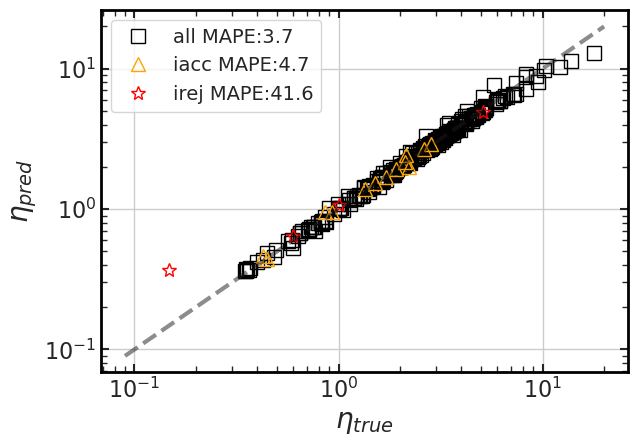

In [37]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(RF_ens_postMD_Vlugt_mape))
ax.plot(Y_interp_accept_raw,RF_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(RF_ens_postMD_iacc_mape))
ax.plot(Y_interp_reject_raw,RF_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(RF_ens_postMD_irej_mape))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("figures/fig-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

## Estimate the errors

### Vlugt data

In [38]:
RF_postMD_Vlugt_eval_t1  = evaluate_mymodel(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
RF_postMD_Vlugt_eval_t1.summary_tofile("ensemble-metrics/RF_postMD_Vlugt_metrics-04aug22.csv")
RF_postMD_Vlugt_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.46E-01    
    MEDIAN            0.05    
    2.5%              0.00    
    97.5%             0.96    
    MAX               4.98    
  MSE               1.81E-01    
  RMSE              4.25E-01    
  R2                0.963040   

  MAPE                3.68    
    MEDIAN            2.19    
    2.5%              0.06    
    97.5%            16.79    
    MAX              33.26    

  ME                 -0.03    
  MPE                 0.20    
    MEDIAN           -0.30    
    2.5%            -10.10    
    97.5%            13.02    
    MAX              33.26    
--------------------------------------------------------------


### All interpolation data

In [39]:
RF_postMD_iall_eval_t1  = evaluate_mymodel(Y_interp_raw,RF_ens_postMD_iall_Ypred_stats_t1.yp_mean_arr)
RF_postMD_iall_eval_t1.summary_tofile("ensemble-metrics/RF_postMD_iall_metrics-04aug22.csv")
RF_postMD_iall_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               8.74E-02    
    MEDIAN            0.06    
    2.5%              0.01    
    97.5%             0.26    
    MAX               0.29    
  MSE               1.48E-02    
  RMSE              1.22E-01    
  R2                0.989183   

  MAPE               13.36    
    MEDIAN            4.00    
    2.5%              0.68    
    97.5%            94.44    
    MAX             148.44    

  ME                  0.03    
  MPE                11.48    
    MEDIAN            2.85    
    2.5%             -7.41    
    97.5%            94.44    
    MAX             148.44    
--------------------------------------------------------------


### Accepted interpolation data

In [40]:
RF_postMD_iacc_eval_t1  = evaluate_mymodel(Y_interp_accept_raw,RF_ens_postMD_iacc_Ypred_stats_t1.yp_mean_arr)
RF_postMD_iacc_eval_t1.summary_tofile("ensemble-metrics/RF_postMD_iacc_metrics-04aug22.csv")
RF_postMD_iacc_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               7.35E-02    
    MEDIAN            0.03    
    2.5%              0.01    
    97.5%             0.27    
    MAX               0.29    
  MSE               1.20E-02    
  RMSE              1.10E-01    
  R2                0.979059   

  MAPE                4.66    
    MEDIAN            2.85    
    2.5%              0.65    
    97.5%            12.81    
    MAX              13.44    

  ME                  0.04    
  MPE                 2.82    
    MEDIAN            2.21    
    2.5%             -7.21    
    97.5%            12.81    
    MAX              13.44    
--------------------------------------------------------------


### Rejected interpolation data

In [41]:
RF_postMD_irej_eval_t1  = evaluate_mymodel(Y_interp_reject_raw,RF_ens_postMD_irej_Ypred_stats_t1.yp_mean_arr)
RF_postMD_irej_eval_t1.summary_tofile("ensemble-metrics/RF_postMD_irej_metrics-04aug22.csv")
RF_postMD_irej_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.33E-01    
    MEDIAN            0.13    
    2.5%              0.05    
    97.5%             0.22    
    MAX               0.22    
  MSE               2.38E-02    
  RMSE              1.54E-01    
  R2                0.993950   

  MAPE               41.63    
    MEDIAN            7.04    
    2.5%              4.13    
    97.5%           137.94    
    MAX             148.44    

  ME                  0.03    
  MPE                39.63    
    MEDIAN            7.04    
    2.5%             -3.27    
    97.5%           137.94    
    MAX             148.44    
--------------------------------------------------------------


## Manuscript plots

### All metrics

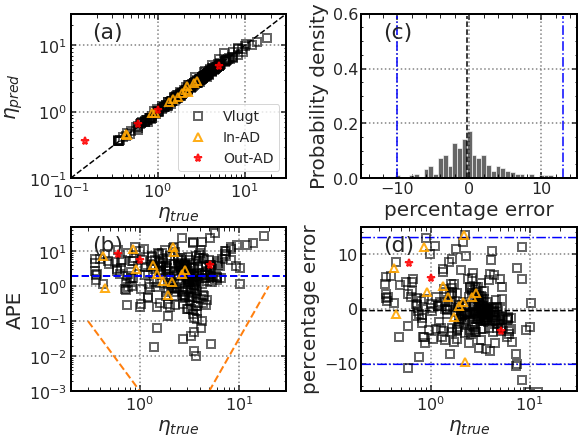

In [42]:
## Load the stylesheet
plt.style.use("../mpl-templates/sifig1.mplstyle")

## Set up some essentials
myaplha=0.6 ; myaplha2 = 0.9
testdata_relerr_mean = 2.0

sf1, sax1 = plt.subplots(nrows=2, ncols=2,
                       sharey=False, sharex=False, gridspec_kw= {"wspace" : 0.05},
                       constrained_layout=True, figsize=(8,6))


## pred visc vs true visc
xlow1, ylow1 = 0.1, 0.1
xhigh1, yhigh1 = 30, 30

stline = np.arange(xlow1,xhigh1,0.01)

sax1[0,0].plot(stline, stline, '--', c='black')
sax1[0,0].plot(RF_postMD_Vlugt_eval_t1.Y_true, RF_postMD_Vlugt_eval_t1.Y_pred,
            marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
            label="Vlugt", zorder=2)
sax1[0,0].plot(RF_postMD_iacc_eval_t1.Y_true, RF_postMD_iacc_eval_t1.Y_pred, 
            marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
            label="In-AD", zorder=4)
sax1[0,0].plot(RF_postMD_irej_eval_t1.Y_true, RF_postMD_irej_eval_t1.Y_pred, 
            marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
            label="Out-AD", zorder=4)


sax1[0,0].set_xlim(xlow1,xhigh1)
sax1[0,0].set_ylim(ylow1,yhigh1)
sax1[0,0].set_xscale("log")
sax1[0,0].set_yscale("log")

sax1[0,0].set_xlabel(r"$\eta_{true}$")
sax1[0,0].set_ylabel(r"$\eta_{pred}$")

sax1[0,0].legend(loc='lower right',fontsize=14)
sax1[0,0].grid(ls=":",lw=1.5)

## APE vs true visc
xlow1, ylow1 = 0.2, 0.001
xhigh1, yhigh1 = 30, 50
    
stline = np.arange(xlow1,xhigh1,0.01)

glinex1 = np.logspace(np.log10(0.3),np.log10(1),num=10,base=10)
gliney1 = np.logspace(-1,-3,num=10,base=10)
glinex2 = np.logspace(np.log10(5),np.log10(20),num=10,base=10)
gliney2 = np.logspace(-3,0,num=10,base=10)

sax1[1,0].plot(RF_postMD_Vlugt_eval_t1.Y_true, RF_postMD_Vlugt_eval_t1.metric_dict['resid_abs_percent'], 
              marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
              label="Train", zorder=2)

sax1[1,0].plot(RF_postMD_iacc_eval_t1.Y_true, RF_postMD_iacc_eval_t1.metric_dict['resid_abs_percent'],
              marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
              label="In-AD", zorder=4)

sax1[1,0].plot(RF_postMD_irej_eval_t1.Y_true, RF_postMD_irej_eval_t1.metric_dict['resid_abs_percent'],
              marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
              label="Out-AD", zorder=4)

sax1[1,0].axhline(y=testdata_relerr_mean, ls="--", lw=2.0, color="blue")
sax1[1,0].plot(glinex1, gliney1,'--',color="tab:orange", lw=2)
sax1[1,0].plot(glinex2, gliney2,'--',color="tab:orange", lw=2)


sax1[1,0].set_xlim(xlow1,xhigh1)
sax1[1,0].set_ylim(ylow1,yhigh1)
sax1[1,0].set_xscale("log")
sax1[1,0].set_yscale("log")

sax1[1,0].set_xlabel(r"$\eta_{true}$")
sax1[1,0].set_ylabel(r"APE")

# sax1[1,0].legend(loc='lower right')
sax1[1,0].grid(ls=":",lw=1.5)


## PE histogram
xlow1, ylow1 = -15, 0
xhigh1, yhigh1 = 15, 0.6
stline = np.arange(ylow1,yhigh1,0.01)

sax1[0,1].plot(0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , stline, 
         '--', c='black') 
sax1[0,1].plot(0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] , stline, 
         '-.', c='blue') 
sax1[0,1].plot(0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] , stline, 
         '-.', c='blue') 

sax1[0,1].hist(RF_postMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         range=(-25,25), bins=75, density=True,
         rwidth=1 , color='black',alpha=0.6 ,label='Vlugt')

sax1[0,1].set_xlim(xlow1,xhigh1)
sax1[0,1].set_ylim(ylow1,yhigh1)

sax1[0,1].set_xlabel("percentage error")
sax1[0,1].set_ylabel("Probability density")

# sax1[0,1].legend()
sax1[0,1].grid(ls=":",lw=1.5)

    
## Residual % vs true visc
xlow1, ylow1 = 0.2, -15
xhigh1, yhigh1 = 30, 15
stline = np.arange(xlow1,xhigh1,0.01)
i=0
sax1[1,1].plot(stline, 0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , 
         '--', c='black') 
sax1[1,1].plot(stline, 0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] ,
         '-.', c='blue') 
sax1[1,1].plot(stline, 0.0*stline + RF_postMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] ,
         '-.', c='blue') 

sax1[1,1].plot(RF_postMD_Vlugt_eval_t1.Y_true, RF_postMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         marker= 's', mec='black', ms=8, alpha=myaplha,
         label="Vlugt")

sax1[1,1].plot(RF_postMD_iacc_eval_t1.Y_true, RF_postMD_iacc_eval_t1.metric_dict['resid_percent'],
         marker= '^', mec='orange', ms=8, alpha=myaplha2,
         label="In-AD")

sax1[1,1].plot(RF_postMD_irej_eval_t1.Y_true, RF_postMD_irej_eval_t1.metric_dict['resid_percent'],
         marker= '*', mec='red', ms=8, alpha=myaplha2,
         label="Out-AD")

sax1[1,1].set_xlim(xlow1,xhigh1)
sax1[1,1].set_ylim(ylow1,yhigh1)
sax1[1,1].set_xscale("log")

sax1[1,1].set_xlabel(r"$\eta_{true}$")
sax1[1,1].set_ylabel(r"percentage error")

# sax1[1,1].legend(loc='upper center')
sax1[1,1].grid(ls=":",lw=1.5)

## Text Labels
sax1[0,0].text(0.1, 0.85,"(a)",transform=sax1[0,0].transAxes,fontsize=22)
sax1[1,0].text(0.1, 0.85,"(b)",transform=sax1[1,0].transAxes,fontsize=22)
sax1[0,1].text(0.1, 0.85,"(c)",transform=sax1[0,1].transAxes,fontsize=22)
sax1[1,1].text(0.1, 0.85,"(d)",transform=sax1[1,1].transAxes,fontsize=22)
    
## Save the figure to file
plt.savefig("figures/sifig-RF-postMD-perf.png",dpi=300)

# Ensemble: preMD

## Predict the labels (eta) of the ensemble model: 
- Vlugt dataset 
- Interpolation set (all,acc,rej)

In [43]:
ft_indx = [0,1,2,3]
RF_best_preMD_model_t1 = RF_hypscan_kfs_preMD_list_t1[RF_kfs_preMD_val_MAE_best_metrics_t1.ndx]
RF_ens_preMD_Vlugt_Ypred_list_t1 = []
RF_ens_preMD_iall_Ypred_list_t1 = []
RF_ens_preMD_iacc_Ypred_list_t1 = []
RF_ens_preMD_irej_Ypred_list_t1 = []

for i in range(RF_best_preMD_model_t1.num_splits):
    for j in range(RF_best_preMD_model_t1.num_folds):
        this_model = RF_best_preMD_model_t1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        RF_ens_preMD_Vlugt_Ypred_list_t1.append(Ypred)
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        RF_ens_preMD_iall_Ypred_list_t1.append(Ypred)
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        RF_ens_preMD_iacc_Ypred_list_t1.append(Ypred)
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        RF_ens_preMD_irej_Ypred_list_t1.append(Ypred)

In [44]:
RF_ens_preMD_Vlugt_Ypred_stats_t1 = stats_ypred(RF_ens_preMD_Vlugt_Ypred_list_t1)
RF_ens_preMD_iall_Ypred_stats_t1 = stats_ypred(RF_ens_preMD_iall_Ypred_list_t1)
RF_ens_preMD_iacc_Ypred_stats_t1 = stats_ypred(RF_ens_preMD_iacc_Ypred_list_t1)
RF_ens_preMD_irej_Ypred_stats_t1 = stats_ypred(RF_ens_preMD_irej_Ypred_list_t1)

In [45]:
RF_ens_preMD_Vlugt_mape = 100*mean_absolute_percentage_error(Y_fset1_raw,RF_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
RF_ens_preMD_iall_mape = 100*mean_absolute_percentage_error(Y_interp_raw,RF_ens_preMD_iall_Ypred_stats_t1.yp_mean_arr)
RF_ens_preMD_iacc_mape = 100*mean_absolute_percentage_error(Y_interp_accept_raw,RF_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr)
RF_ens_preMD_irej_mape = 100*mean_absolute_percentage_error(Y_interp_reject_raw,RF_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr)

## Plot the results

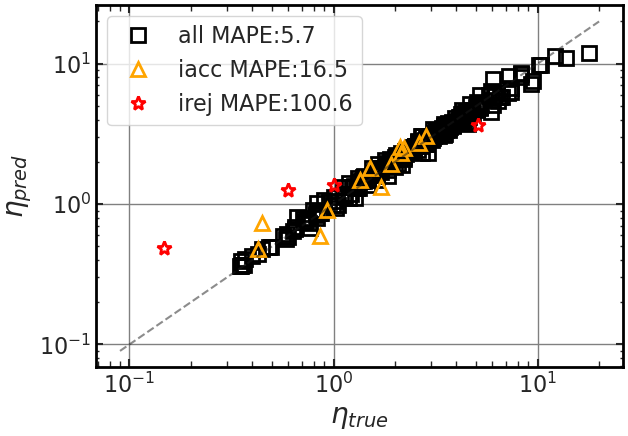

In [46]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,RF_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(RF_ens_preMD_Vlugt_mape))
ax.plot(Y_interp_accept_raw,RF_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(RF_ens_preMD_iacc_mape))
ax.plot(Y_interp_reject_raw,RF_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(RF_ens_preMD_irej_mape))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("figures/fig-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

## Estimate the errors

### Vlugt data

In [47]:
RF_preMD_Vlugt_eval_t1  = evaluate_mymodel(Y_fset1_raw,RF_ens_preMD_Vlugt_Ypred_stats_t1.yp_mean_arr)
RF_preMD_Vlugt_eval_t1.summary_tofile("ensemble-metrics/RF_preMD_Vlugt_metrics-04aug22.csv")
RF_preMD_Vlugt_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               2.08E-01    
    MEDIAN            0.09    
    2.5%              0.01    
    97.5%             1.01    
    MAX               6.06    
  MSE               2.65E-01    
  RMSE              5.15E-01    
  R2                0.945787   

  MAPE                5.74    
    MEDIAN            4.16    
    2.5%              0.27    
    97.5%            20.26    
    MAX              33.79    

  ME                 -0.07    
  MPE                 0.37    
    MEDIAN            0.62    
    2.5%            -16.52    
    97.5%            16.70    
    MAX              28.63    
--------------------------------------------------------------


### All interpolation data

In [48]:
RF_preMD_iall_eval_t1  = evaluate_mymodel(Y_interp_raw,RF_ens_preMD_iall_Ypred_stats_t1.yp_mean_arr)
RF_preMD_iall_eval_t1.summary_tofile("ensemble-metrics/RF_preMD_iall_metrics-04aug22.csv")
RF_preMD_iall_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               3.21E-01    
    MEDIAN            0.28    
    2.5%              0.01    
    97.5%             1.13    
    MAX               1.45    
  MSE               2.09E-01    
  RMSE              4.57E-01    
  R2                0.847196   

  MAPE               36.28    
    MEDIAN           19.87    
    2.5%              1.08    
    97.5%           180.87    
    MAX             228.31    

  ME                  0.07    
  MPE                26.51    
    MEDIAN           11.25    
    2.5%            -29.64    
    97.5%           180.87    
    MAX             228.31    
--------------------------------------------------------------


### Accepted interpolation data

In [49]:
RF_preMD_iacc_eval_t1  = evaluate_mymodel(Y_interp_accept_raw,RF_ens_preMD_iacc_Ypred_stats_t1.yp_mean_arr)
RF_preMD_iacc_eval_t1.summary_tofile("ensemble-metrics/RF_preMD_iacc_metrics-04aug22.csv")
RF_preMD_iacc_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               2.04E-01    
    MEDIAN            0.21    
    2.5%              0.01    
    97.5%             0.41    
    MAX               0.42    
  MSE               5.92E-02    
  RMSE              2.43E-01    
  R2                0.896788   

  MAPE               16.47    
    MEDIAN           11.38    
    2.5%              1.06    
    97.5%            53.85    
    MAX              63.86    

  ME                  0.10    
  MPE                 8.06    
    MEDIAN            8.15    
    2.5%            -28.24    
    97.5%            50.79    
    MAX              63.86    
--------------------------------------------------------------


### Rejected interpolation data

In [50]:
RF_preMD_irej_eval_t1  = evaluate_mymodel(Y_interp_reject_raw,RF_ens_preMD_irej_Ypred_stats_t1.yp_mean_arr)
RF_preMD_irej_eval_t1.summary_tofile("ensemble-metrics/RF_preMD_irej_metrics-04aug22.csv")
RF_preMD_irej_eval_t1.summary()

--------------------------------------------------------------
  score             test                
  MAE               7.02E-01    
    MEDIAN            0.51    
    2.5%              0.34    
    97.5%             1.39    
    MAX               1.45    
  MSE               6.96E-01    
  RMSE              8.34E-01    
  R2                0.823490   

  MAPE              100.65    
    MEDIAN           72.96    
    2.5%             28.96    
    97.5%           219.41    
    MAX             228.31    

  ME                 -0.02    
  MPE                86.46    
    MEDIAN           72.96    
    2.5%            -23.53    
    97.5%           219.41    
    MAX             228.31    
--------------------------------------------------------------


## Manuscript plots

### All metrics

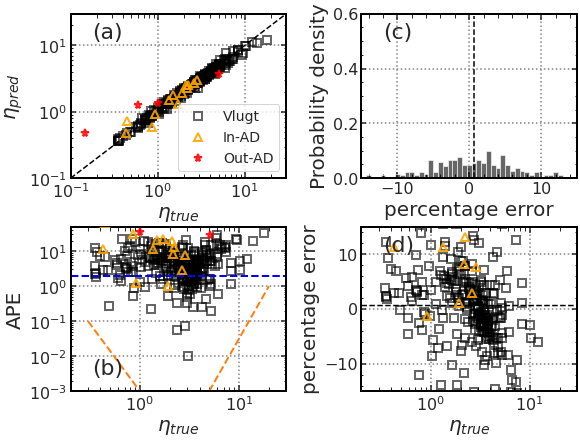

In [51]:
## Load the stylesheet
plt.style.use("../mpl-templates/sifig1.mplstyle")

## Set up some essentials
myaplha=0.6 ; myaplha2 = 0.9
testdata_relerr_mean = 2.0

sf1, sax1 = plt.subplots(nrows=2, ncols=2,
                       sharey=False, sharex=False, gridspec_kw= {"wspace" : 0.05},
                       constrained_layout=True, figsize=(8,6))


## pred visc vs true visc
xlow1, ylow1 = 0.1, 0.1
xhigh1, yhigh1 = 30, 30

stline = np.arange(xlow1,xhigh1,0.01)

sax1[0,0].plot(stline, stline, '--', c='black')
sax1[0,0].plot(RF_preMD_Vlugt_eval_t1.Y_true, RF_preMD_Vlugt_eval_t1.Y_pred,
            marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
            label="Vlugt", zorder=2)
sax1[0,0].plot(RF_preMD_iacc_eval_t1.Y_true, RF_preMD_iacc_eval_t1.Y_pred, 
            marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
            label="In-AD", zorder=4)
sax1[0,0].plot(RF_preMD_irej_eval_t1.Y_true, RF_preMD_irej_eval_t1.Y_pred, 
            marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
            label="Out-AD", zorder=4)


sax1[0,0].set_xlim(xlow1,xhigh1)
sax1[0,0].set_ylim(ylow1,yhigh1)
sax1[0,0].set_xscale("log")
sax1[0,0].set_yscale("log")

sax1[0,0].set_xlabel(r"$\eta_{true}$")
sax1[0,0].set_ylabel(r"$\eta_{pred}$")

sax1[0,0].legend(loc='lower right',fontsize=14)
sax1[0,0].grid(ls=":",lw=1.5)

## APE vs true visc
xlow1, ylow1 = 0.2, 0.001
xhigh1, yhigh1 = 30, 50
    
stline = np.arange(xlow1,xhigh1,0.01)

glinex1 = np.logspace(np.log10(0.3),np.log10(1),num=10,base=10)
gliney1 = np.logspace(-1,-3,num=10,base=10)
glinex2 = np.logspace(np.log10(5),np.log10(20),num=10,base=10)
gliney2 = np.logspace(-3,0,num=10,base=10)

sax1[1,0].plot(RF_preMD_Vlugt_eval_t1.Y_true, RF_preMD_Vlugt_eval_t1.metric_dict['resid_abs_percent'], 
              marker= 's', mec='black', mfc=None, ms=8, alpha=myaplha,
              label="Train", zorder=2)

sax1[1,0].plot(RF_preMD_iacc_eval_t1.Y_true, RF_preMD_iacc_eval_t1.metric_dict['resid_abs_percent'],
              marker= '^', mec='orange', mfc=None, ms=8, alpha=myaplha2,
              label="In-AD", zorder=4)

sax1[1,0].plot(RF_preMD_irej_eval_t1.Y_true, RF_preMD_irej_eval_t1.metric_dict['resid_abs_percent'],
              marker= '*', mec='red', mfc=None, ms=8, alpha=myaplha2,
              label="Out-AD", zorder=4)

sax1[1,0].axhline(y=testdata_relerr_mean, ls="--", lw=2.0, color="blue")
sax1[1,0].plot(glinex1, gliney1,'--',color="tab:orange", lw=2)
sax1[1,0].plot(glinex2, gliney2,'--',color="tab:orange", lw=2)


sax1[1,0].set_xlim(xlow1,xhigh1)
sax1[1,0].set_ylim(ylow1,yhigh1)
sax1[1,0].set_xscale("log")
sax1[1,0].set_yscale("log")

sax1[1,0].set_xlabel(r"$\eta_{true}$")
sax1[1,0].set_ylabel(r"APE")

# sax1[1,0].legend(loc='lower right')
sax1[1,0].grid(ls=":",lw=1.5)


## PE histogram
xlow1, ylow1 = -15, 0
xhigh1, yhigh1 = 15, 0.6
stline = np.arange(ylow1,yhigh1,0.01)

sax1[0,1].plot(0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , stline, 
         '--', c='black') 
sax1[0,1].plot(0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] , stline, 
         '-.', c='blue') 
sax1[0,1].plot(0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] , stline, 
         '-.', c='blue') 

sax1[0,1].hist(RF_preMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         range=(-25,25), bins=75, density=True,
         rwidth=1 , color='black',alpha=0.6 ,label='Vlugt')

sax1[0,1].set_xlim(xlow1,xhigh1)
sax1[0,1].set_ylim(ylow1,yhigh1)

sax1[0,1].set_xlabel("percentage error")
sax1[0,1].set_ylabel("Probability density")

# sax1[0,1].legend()
sax1[0,1].grid(ls=":",lw=1.5)

    
## Residual % vs true visc
xlow1, ylow1 = 0.2, -15
xhigh1, yhigh1 = 30, 15
stline = np.arange(xlow1,xhigh1,0.01)
i=0
sax1[1,1].plot(stline, 0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['median'] , 
         '--', c='black') 
sax1[1,1].plot(stline, 0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_2p5'] ,
         '-.', c='blue') 
sax1[1,1].plot(stline, 0.0*stline + RF_preMD_Vlugt_eval_t1.metric_dict['stats']['resid_percent']['ptile_97p5'] ,
         '-.', c='blue') 

sax1[1,1].plot(RF_preMD_Vlugt_eval_t1.Y_true, RF_preMD_Vlugt_eval_t1.metric_dict['resid_percent'], 
         marker= 's', mec='black', ms=8, alpha=myaplha,
         label="Vlugt")

sax1[1,1].plot(RF_preMD_iacc_eval_t1.Y_true, RF_preMD_iacc_eval_t1.metric_dict['resid_percent'],
         marker= '^', mec='orange', ms=8, alpha=myaplha2,
         label="In-AD")

sax1[1,1].plot(RF_preMD_irej_eval_t1.Y_true, RF_preMD_irej_eval_t1.metric_dict['resid_percent'],
         marker= '*', mec='red', ms=8, alpha=myaplha2,
         label="Out-AD")

sax1[1,1].set_xlim(xlow1,xhigh1)
sax1[1,1].set_ylim(ylow1,yhigh1)
sax1[1,1].set_xscale("log")

sax1[1,1].set_xlabel(r"$\eta_{true}$")
sax1[1,1].set_ylabel(r"percentage error")

# sax1[1,1].legend(loc='upper center')
sax1[1,1].grid(ls=":",lw=1.5)

## Text Labels
sax1[0,0].text(0.1, 0.85,"(a)",transform=sax1[0,0].transAxes,fontsize=22)
sax1[1,0].text(0.1, 0.10,"(b)",transform=sax1[1,0].transAxes,fontsize=22)
sax1[0,1].text(0.1, 0.85,"(c)",transform=sax1[0,1].transAxes,fontsize=22)
sax1[1,1].text(0.1, 0.85,"(d)",transform=sax1[1,1].transAxes,fontsize=22)
    
## Save the figure to file
plt.savefig("figures/sifig-RF-preMD-perf.png",dpi=300)

# Model interpolation
- x1_int
- sig2_int
- eps2_int
- k12_int

### preMD scaling

In [52]:
## transform the features if necessary
preMD_X_raw = X_2000p_fset1_raw[:,0:4]
preMD_sc = MinMaxScaler() ## Needs a 2D array -- if only a single feature, use reshape
preMD_sc.fit(preMD_X_raw) 
tmparr = preMD_sc.transform(preMD_X_raw)
print("X scaled : ", tmparr.shape)

X scaled :  (273, 4)


### Construct the interpolation grid

In [53]:
## Values used to construct the original X grid
x1_vals = [0.10, 0.30, 0.50, 0.70, 0.90] ; num_x1_vals = len(x1_vals)
eps2_vals = [0.50, 0.60, 0.80, 1.00] ; num_eps2_vals = len(eps2_vals)
sig2_vals = [1.0, 1.20, 1.40, 1.60] ; num_sig2_vals = len(sig2_vals)
k12_vals = [-0.60, -0.30, 0.00, 0.05] ; num_k12_vals = len(k12_vals)

In [54]:
## construct the total Vlugt grid
num_vlugt_grid_vals = num_x1_vals*num_eps2_vals*num_sig2_vals*num_k12_vals
print("Num of Vlugt grid points: ",num_vlugt_grid_vals)

vlugt_grid = np.zeros((num_vlugt_grid_vals,4))
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                vlugt_grid[cntr,:] = [x1_vals[i],eps2_vals[j],sig2_vals[k],k12_vals[l]]
                cntr += 1

## Get a scaled version
vlugt_grid_scaled = preMD_sc.transform(vlugt_grid)
# print("Raw grid   : ", vlugt_grid[0:2,:])
# print("Scaled grid: ", vlugt_grid_scaled[0:2,:])
print("Raw grid   : ", vlugt_grid.shape)
print("Scaled grid: ", vlugt_grid_scaled.shape)

## Locate holes
vlugt_holes = [] ; num_vlugt_holes = 0
for p in vlugt_grid:
    mindist = 2
    for d in preMD_X_raw:
        dist = np.linalg.norm(p-d)
        if (dist < mindist):
            mindist = dist
    if (mindist > 0.0001):
        vlugt_holes.append(p)
        num_vlugt_holes += 1
        
vlugt_holes = np.array(vlugt_holes)  
vlugt_holes_scaled = preMD_sc.transform(vlugt_holes)
print("Num holes  : ", num_vlugt_holes)
print("Vlugt holes: ", vlugt_holes.shape)
print("Vlugt holes: ", vlugt_holes[0:2,:])

# All data grid scales
preMD_X_raw_scaled = preMD_sc.transform(preMD_X_raw)

Num of Vlugt grid points:  320
Raw grid   :  (320, 4)
Scaled grid:  (320, 4)
Num holes  :  47
Vlugt holes:  (47, 4)
Vlugt holes:  [[0.1  0.5  1.   0.  ]
 [0.1  0.5  1.   0.05]]


In [55]:
## Create X_in -- a grid of values within X range by changing 1 feature at a time
num_in = 19 ; num_features = 4
print("Num of grid points: ",num_in)
print()

#### x1 interpolation ####
x1_int_vals = [] ; delx = x1_vals[num_x1_vals-1] - x1_vals[0] ; minx = x1_vals[0]
for i in range(1, num_in+1):
    x1_int_vals.append(minx + i*delx/(num_in+1.0))
print("x1 Grid values       : ",x1_int_vals)

num_x1_int_data = num_in*(num_eps2_vals*num_sig2_vals*num_k12_vals)
print("Num of interpolated points: ",num_x1_int_data)
assert num_x1_int_data < 100000 # a check to keep the program from crashing
x1_int = np.zeros((num_x1_int_data,num_features)) 
cntr = 0
for i in range(num_in):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                tmp = np.array([x1_int_vals[i], eps2_vals[j], sig2_vals[k], k12_vals[l]])
                x1_int[cntr,:] = tmp.copy()
                cntr +=1
x1_int = preMD_sc.transform(x1_int)
print("x1 interpolate shape: ", x1_int.shape)
print()

#### eps2 interpolation ####
eps2_int_vals = [] ; delx = eps2_vals[num_eps2_vals-1] - eps2_vals[0] ; minx = eps2_vals[0]
for i in range(1, num_in+1):
    eps2_int_vals.append(minx + i*delx/(num_in+1.0))
print("eps2 Grid values       : ",eps2_int_vals)  

num_eps2_int_data = num_in*(num_x1_vals*num_sig2_vals*num_k12_vals)
print("Num of interpolated points: ",num_eps2_int_data)
assert num_eps2_int_data < 100000 # a check to keep the program from crashing
eps2_int = np.zeros((num_eps2_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_in):
        for k in range(num_sig2_vals):
            for l in range(num_k12_vals):
                tmp = np.array([x1_vals[i], eps2_int_vals[j], sig2_vals[k], k12_vals[l]])
                eps2_int[cntr,:] = tmp.copy()
                cntr +=1
eps2_int = preMD_sc.transform(eps2_int)
print("eps2 interpolate shape: ", eps2_int.shape)
print()

#### sig2 interpolation ####
sig2_int_vals = [] ; delx = sig2_vals[num_sig2_vals-1] - sig2_vals[0] ; minx = sig2_vals[0]
for i in range(1, num_in+1):
    sig2_int_vals.append(minx + i*delx/(num_in+1.0))
print("sig2 Grid values       : ",sig2_int_vals)

num_sig2_int_data = num_in*(num_x1_vals*num_eps2_vals*num_k12_vals)
print("Num of interpolated points: ",num_sig2_int_data)
assert num_sig2_int_data < 100000 # a check to keep the program from crashing
sig2_int = np.zeros((num_sig2_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_in):
            for l in range(num_k12_vals):
                tmp = np.array([x1_vals[i], eps2_vals[j], sig2_int_vals[k], k12_vals[l]])
                sig2_int[cntr,:] = tmp.copy()
                cntr +=1
sig2_int = preMD_sc.transform(sig2_int)
print("sig2 interpolate shape: ", sig2_int.shape)
print()

#### k12 interpolation ####
k12_int_vals = [] ; delx = k12_vals[num_k12_vals-1] - k12_vals[0] ; minx = k12_vals[0]
for i in range(1, num_in+1):
    k12_int_vals.append(minx + i*delx/(num_in+1.0))
print("k12 Grid values       : ",k12_int_vals) 

num_k12_int_data = num_in*(num_x1_vals*num_eps2_vals*num_sig2_vals)
print("Num of interpolated points: ",num_k12_int_data)
assert num_k12_int_data < 100000 # a check to keep the program from crashing
k12_int = np.zeros((num_k12_int_data,num_features)) 
cntr = 0
for i in range(num_x1_vals):
    for j in range(num_eps2_vals):
        for k in range(num_sig2_vals):
            for l in range(num_in):
                tmp = np.array([x1_vals[i], eps2_vals[j], sig2_vals[k], k12_int_vals[l]])
                k12_int[cntr,:] = tmp.copy()
                cntr +=1
k12_int = preMD_sc.transform(k12_int)
print("k12 interpolate shape: ", k12_int.shape)
print()

Num of grid points:  19

x1 Grid values       :  [0.14, 0.18, 0.22000000000000003, 0.26, 0.30000000000000004, 0.3400000000000001, 0.38, 0.42000000000000004, 0.45999999999999996, 0.5, 0.54, 0.5800000000000001, 0.62, 0.66, 0.7, 0.74, 0.78, 0.82, 0.86]
Num of interpolated points:  1216
x1 interpolate shape:  (1216, 4)

eps2 Grid values       :  [0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
Num of interpolated points:  1520
eps2 interpolate shape:  (1520, 4)

sig2 Grid values       :  [1.03, 1.06, 1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27, 1.3, 1.33, 1.36, 1.3900000000000001, 1.4200000000000002, 1.4500000000000002, 1.48, 1.51, 1.54, 1.57]
Num of interpolated points:  1520
sig2 interpolate shape:  (1520, 4)

k12 Grid values       :  [-0.5675, -0.5349999999999999, -0.5025, -0.47, -0.4375, -0.40499999999999997, -0.3725, -0.33999999999999997, -0.30749999999999994, -0.27499999999999997, -0.24249999999999994, -0.2099999999

In [56]:
#### Color code the points w.r.t the distance from the nearest training point ####
# if  train_dist > vlugt_dist -> the point is closer to test than train set
# if  vlugt_dist > grid_dist  -> the point is closer to hole than train/test set

#### x1 interpolation distance ####
tic = time.perf_counter()
x1_train_dist = [] ; x1_vlugt_dist = [] ; x1_grid_dist = [] ; x1_hole_bool = []

indxlist = [1,2,3] ; cntr = 0
for x in x1_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    x1_grid_dist.append(mindist)

    if (x1_vlugt_dist[cntr] - x1_grid_dist[cntr] > 0.0001):
        x1_hole_bool.append(True)
    else:
        x1_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### eps2 interpolation distance ####
tic = time.perf_counter()
eps2_train_dist = [] ; eps2_vlugt_dist = [] ; eps2_grid_dist = [] ; eps2_hole_bool = []

indxlist = [0,2,3] ; cntr = 0
for x in eps2_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    eps2_grid_dist.append(mindist)

    if (eps2_vlugt_dist[cntr] - eps2_grid_dist[cntr] > 0.0001):
        eps2_hole_bool.append(True)
    else:
        eps2_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### sig2 interpolation distance ####
tic = time.perf_counter()
sig2_train_dist = [] ; sig2_vlugt_dist = [] ; sig2_grid_dist = [] ; sig2_hole_bool = []

indxlist = [0,1,3] ; cntr = 0
for x in sig2_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    sig2_grid_dist.append(mindist)

    if (sig2_vlugt_dist[cntr] - sig2_grid_dist[cntr] > 0.0001):
        sig2_hole_bool.append(True)
    else:
        sig2_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

#### k12 interpolation distance ####
tic = time.perf_counter()
k12_train_dist = [] ; k12_vlugt_dist = [] ; k12_grid_dist = [] ; k12_hole_bool = []

indxlist = [0,1,2] ; cntr = 0
for x in k12_int:
    mindist = 4
    # training grid distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_train_dist.append(mindist)

    # Vlugt distance
    for y in preMD_X_raw_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_vlugt_dist.append(mindist)

    # ideal grid distance
    for y in vlugt_holes_scaled:
        # tmpdist = np.sum(np.square(x[indxlist]-y[indxlist]))
        tmpdist = np.linalg.norm(x-y)
        if tmpdist < mindist:
            mindist = tmpdist
    k12_grid_dist.append(mindist)

    if (k12_vlugt_dist[cntr] - k12_grid_dist[cntr] > 0.0001):
        k12_hole_bool.append(True)
    else:
        k12_hole_bool.append(False)

    cntr += 1

toc = time.perf_counter()
print("Time: ",toc-tic)

Time:  3.7874308549799025
Time:  4.834463251987472
Time:  4.820490992045961
Time:  4.996167381992564


In [57]:
tst = list(map(int, x1_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, eps2_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, sig2_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))
tst = list(map(int, k12_hole_bool))
print("Num int closer to holes : ", np.sum(tst), len(tst), np.sum(tst)/len(tst))

Num int closer to holes :  205 1216 0.16858552631578946
Num int closer to holes :  137 1520 0.09013157894736842
Num int closer to holes :  216 1520 0.14210526315789473
Num int closer to holes :  134 1520 0.0881578947368421


### Evaluate the models at interpolated points

In [58]:
ft_indx = [0,1,2,3]
RF_best_preMD_model_t1 = RF_hypscan_kfs_preMD_list_t1[RF_kfs_preMD_val_MAE_best_metrics_t1.ndx]
RF_ens_x1_int_Ypred_list_t1 = []
RF_ens_sig2_int_Ypred_list_t1 = []
RF_ens_eps2_int_Ypred_list_t1 = []
RF_ens_k12_int_Ypred_list_t1 = []

for i in range(RF_best_preMD_model_t1.num_splits):
    for j in range(RF_best_preMD_model_t1.num_folds):
        this_model = RF_best_preMD_model_t1.trained_model_dbllist[i][j]
        ## x1-int
        Ypred = np.power(10,this_model.predict(x1_int[:,ft_indx]))
        RF_ens_x1_int_Ypred_list_t1.append(Ypred)
        
        ## sig2-int
        Ypred = np.power(10,this_model.predict(sig2_int[:,ft_indx]))
        RF_ens_sig2_int_Ypred_list_t1.append(Ypred)
        
        ## eps2-int
        Ypred = np.power(10,this_model.predict(eps2_int[:,ft_indx]))
        RF_ens_eps2_int_Ypred_list_t1.append(Ypred)
        
        ## k12-int
        Ypred = np.power(10,this_model.predict(k12_int[:,ft_indx]))
        RF_ens_k12_int_Ypred_list_t1.append(Ypred)

In [59]:
RF_ens_x1_int_Ypred_stats_t1 = stats_ypred(RF_ens_x1_int_Ypred_list_t1)
RF_ens_eps2_int_Ypred_stats_t1 = stats_ypred(RF_ens_eps2_int_Ypred_list_t1)
RF_ens_sig2_int_Ypred_stats_t1 = stats_ypred(RF_ens_sig2_int_Ypred_list_t1)
RF_ens_k12_int_Ypred_stats_t1 = stats_ypred(RF_ens_k12_int_Ypred_list_t1)

## Figure 4 - Model interpolation

In [1]:
from matplotlib import cm
cmap1 = cm.get_cmap('viridis_r')
alpha1 = 1.0 ; alpha2 = 0.6

plt.style.use("../mpl-templates/interpolate.mplstyle")
mpl.rcParams['lines.markersize'] = 9
mpl.rcParams['lines.markerfacecolor'] = 'None'
mpl.rcParams['lines.markeredgecolor'] = 'black'
mpl.rcParams['lines.markeredgewidth'] = 0.5
mpl.rcParams['markers.fillstyle'] = 'none'
label_str = ['X_1', 'epsilon_2', 'sigma_2', 'k_12']

sf6, sax6 = plt.subplots(nrows=2, ncols=2, 
                       sharey=True, sharex=True, gridspec_kw= {"wspace" : 0.05},
                       figsize=(18,12))
cntr = 0
for i in range(2):
    for j in range(2):
        sax6[i,j].scatter(X_2000p_fset1_scaled[:,cntr], Y_fset1_raw,
                        marker="D", alpha=alpha2, c="red", label="Vlugt", linewidths=(1.5,))
        
        for spine in sax6[i,j].spines.values():
            spine.set_edgecolor('black')

        sax6[i,j].set_ylabel(r"$\eta$")
        sax6[i,j].set_yscale("log")
        sax6[i,j].grid(ls=":")
        cntr += 1 

#### x1 interpolation ####
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['markers.fillstyle'] = 'full'
sim1 = sax6[0,0].scatter(x1_int[:,0], RF_ens_x1_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
                   c=x1_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
                   alpha=alpha1, 
                   label="Interpolation")

#### eps2 interpolation ####
sim2 = sax6[0,1].scatter(eps2_int[:,1], RF_ens_eps2_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
           c=eps2_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
           alpha=alpha1, 
           label="Interpolation")

#### sig2 interpolation ####
sim3 = sax6[1,0].scatter(sig2_int[:,2], RF_ens_sig2_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
           c=sig2_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
           alpha=alpha1, 
           label="Interpolation")

#### k12 interpolation ####
sim4 = sax6[1,1].scatter(k12_int[:,3], RF_ens_k12_int_Ypred_stats_t1.yp_mean_arr, marker = "_",
                 c=k12_vlugt_dist, cmap=cmap1, vmin=0, vmax=0.2,
                 alpha=alpha1, 
                 label="Interpolation")
ticklist = [0.0, 0.05, 0.10, 0.15, 0.20]
sf6.colorbar(sim1, ax=sax6[0,0],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim2, ax=sax6[0,1],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim3, ax=sax6[1,0],
             location = "right",
             ticks= ticklist, format='%.2f')
sf6.colorbar(sim4, ax=sax6[1,1],
             location = "right",
             ticks= ticklist, format='%.2f')

sax6[0,0].set_xlabel(r"X$_1$")
sax6[1,0].set_xlabel(r"$\sigma_2$")
sax6[0,1].set_xlabel(r"$\epsilon_2$")
sax6[1,1].set_xlabel(r"k$_{12}$")

plt.legend()
plt.savefig("figures/sfig-RF-ens-interpolation.png",dpi=300)

NameError: name 'plt' is not defined

# Save to files
- pickle.dump(obj, open(fname,'wb'))
- pickle.load(open(savepath+'test1.obj', 'rb'))

## Test saving the models

### save and load 

In [61]:
savepath = "best-models/"

## Save the models
saveobj = RF_hypscan_kfs_postMD_list_t1[RF_kfs_postMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'test1.obj', 'wb'))

## Save the metrics
saveobj = RF_hypscan_kfs_metrics_postMD_list_t1[RF_kfs_postMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'test2.obj', 'wb'))

In [62]:
test1_loadobj = pickle.load(open(savepath+'test1.obj', 'rb'))
test2_loadobj = pickle.load(open(savepath+'test2.obj', 'rb'))

In [63]:
dir(test1_loadobj)

['Y_pred_interp_dbllist',
 'Y_pred_test_dbllist',
 'Y_pred_train_dbllist',
 'Y_pred_val_dbllist',
 'Yerr_pred_interp_dbllist',
 'Yerr_pred_test_dbllist',
 'Yerr_pred_train_dbllist',
 'Yerr_pred_val_dbllist',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'best_hyperparameter_dict',
 'fit_model_list',
 'ft_indx',
 'num_fit_pts',
 'num_folds',
 'num_interp_pts',
 'num_splits',
 'num_test_pts',
 'num_train_pts',
 'num_val_pts',
 'predict',
 'predict_for_performance_evaluation',
 'trained_model_dbllist']

### Test the loaded object

In [64]:
ft_indx = [0,1,2,3,4,5]
RF_best_postMD_model_tl1 = test1_loadobj
RF_ens_postMD_Vlugt_Ypred_list_tl1 = []
RF_ens_postMD_iall_Ypred_list_tl1 = []
RF_ens_postMD_iacc_Ypred_list_tl1 = []
RF_ens_postMD_irej_Ypred_list_tl1 = []

for i in range(RF_best_postMD_model_tl1.num_splits):
    for j in range(RF_best_postMD_model_tl1.num_folds):
        this_model = RF_best_postMD_model_tl1.trained_model_dbllist[i][j]
        ## Vlugt data
        Ypred = np.power(10,this_model.predict(X_2000p_fset1_scaled[:,ft_indx]))
        RF_ens_postMD_Vlugt_Ypred_list_tl1.append(Ypred)
        
        ## All Interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_fset1_scaled[:,ft_indx]))
        RF_ens_postMD_iall_Ypred_list_tl1.append(Ypred)
        
        ## Accepted interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_accept_scaled[:,ft_indx]))
        RF_ens_postMD_iacc_Ypred_list_tl1.append(Ypred)
        
        ## Rejected interpolation data
        Ypred = np.power(10,this_model.predict(X_interp_reject_scaled[:,ft_indx]))
        RF_ens_postMD_irej_Ypred_list_tl1.append(Ypred)

RF_ens_postMD_Vlugt_Ypred_stats_tl1 = stats_ypred(RF_ens_postMD_Vlugt_Ypred_list_tl1)
RF_ens_postMD_iall_Ypred_stats_tl1 = stats_ypred(RF_ens_postMD_iall_Ypred_list_tl1)
RF_ens_postMD_iacc_Ypred_stats_tl1 = stats_ypred(RF_ens_postMD_iacc_Ypred_list_tl1)
RF_ens_postMD_irej_Ypred_stats_tl1 = stats_ypred(RF_ens_postMD_irej_Ypred_list_tl1)

RF_ens_postMD_Vlugt_mape_tl1 = 100*mean_absolute_percentage_error(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr)
RF_ens_postMD_iall_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_raw,RF_ens_postMD_iall_Ypred_stats_tl1.yp_mean_arr)
RF_ens_postMD_iacc_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_accept_raw,RF_ens_postMD_iacc_Ypred_stats_tl1.yp_mean_arr)
RF_ens_postMD_irej_mape_tl1 = 100*mean_absolute_percentage_error(Y_interp_reject_raw,RF_ens_postMD_irej_Ypred_stats_tl1.yp_mean_arr)


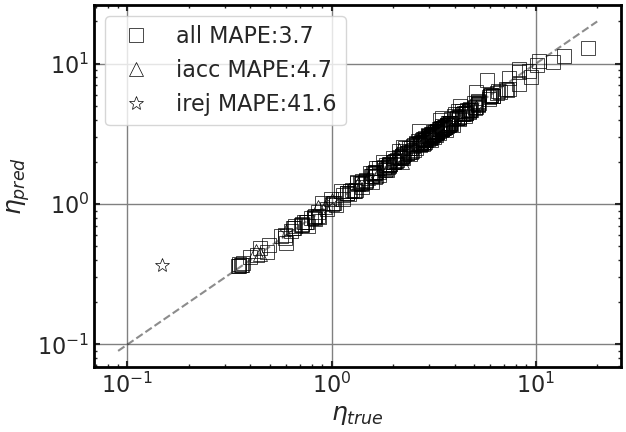

In [65]:
f,ax = plt.subplots(1,1,figsize=(6.8,4.8),dpi=100)

stline = np.arange(0.09,20,0.01)

ax.plot(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr,
        "s",c="black",mfc="none",label="all MAPE:{:.1f}".format(RF_ens_postMD_Vlugt_mape_tl1))
ax.plot(Y_interp_accept_raw,RF_ens_postMD_iacc_Ypred_stats_tl1.yp_mean_arr,
        "^",c="orange",mfc="none",label="iacc MAPE:{:.1f}".format(RF_ens_postMD_iacc_mape_tl1))
ax.plot(Y_interp_reject_raw,RF_ens_postMD_irej_Ypred_stats_tl1.yp_mean_arr,
        "*",c="red",mfc="none",label="irej MAPE:{:.1f}".format(RF_ens_postMD_irej_mape_tl1))
ax.plot(stline,stline,"k--",alpha=0.5)

ax.legend()
ax.set_xscale("log") ; ax.set_yscale("log")
ax.set_xlabel(r"$\eta_{true}$") ; ax.set_ylabel(r"$\eta_{pred}$")
plt.savefig("best-models/fig-ytrue-vs-ENSpred.png",dpi=300,bbox_inches='tight')

In [66]:
RF_postMD_Vlugt_eval_tl1  = evaluate_mymodel(Y_fset1_raw,RF_ens_postMD_Vlugt_Ypred_stats_tl1.yp_mean_arr)
RF_postMD_Vlugt_eval_tl1.summary_tofile("best-models/RF_postMD_Vlugt_metrics-11aug22.csv")
RF_postMD_Vlugt_eval_tl1.summary()

--------------------------------------------------------------
  score             test                
  MAE               1.46E-01    
    MEDIAN            0.05    
    2.5%              0.00    
    97.5%             0.96    
    MAX               4.98    
  MSE               1.81E-01    
  RMSE              4.25E-01    
  R2                0.963040   

  MAPE                3.68    
    MEDIAN            2.19    
    2.5%              0.06    
    97.5%            16.79    
    MAX              33.26    

  ME                 -0.03    
  MPE                 0.20    
    MEDIAN           -0.30    
    2.5%            -10.10    
    97.5%            13.02    
    MAX              33.26    
--------------------------------------------------------------


### Test the loaded metrics object

In [67]:
print(test2_loadobj.MSE_train_q2p5)
print(test2_loadobj.MSE_train_median)
print(test2_loadobj.MSE_train_avg)
print(test2_loadobj.MSE_train_q97p5)

0.037772573736020346
0.08576645776813843
0.07825412171615623
0.10964901451200816


## The best postMD models + metrics

In [68]:
savepath = "best-models/"

## Save the models
saveobj = RF_hypscan_kfs_postMD_list_t1[RF_kfs_postMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'RF-best-postMD-models.obj', 'wb'))

## Save the metrics
saveobj = RF_hypscan_kfs_metrics_postMD_list_t1[RF_kfs_postMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'RF-best-postMD-metrics.obj', 'wb'))

## The best preMD models + metrics

In [69]:
savepath = "best-models/"

## Save the models
saveobj = RF_hypscan_kfs_preMD_list_t1[RF_kfs_preMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'RF-best-preMD-models.obj', 'wb'))

## Save the metrics
saveobj = RF_hypscan_kfs_metrics_preMD_list_t1[RF_kfs_preMD_val_MAE_best_metrics_t1.ndx]
pickle.dump(saveobj, open(savepath+'RF-best-preMD-metrics.obj', 'wb'))

## The ensemble results

### postMD results

In [70]:
## Save the models
saveobj = RF_ens_postMD_Vlugt_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-postMD-Vlugt-ypred.obj', 'wb'))

saveobj = RF_ens_postMD_iall_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-postMD-iall-ypred.obj', 'wb'))

saveobj = RF_ens_postMD_iacc_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-postMD-iacc-ypred.obj', 'wb'))

saveobj = RF_ens_postMD_irej_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-postMD-irej-ypred.obj', 'wb'))

### preMD results

In [71]:
## Save the models
saveobj = RF_ens_preMD_Vlugt_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-preMD-Vlugt-ypred.obj', 'wb'))

saveobj = RF_ens_preMD_iall_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-preMD-iall-ypred.obj', 'wb'))

saveobj = RF_ens_preMD_iacc_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-preMD-iacc-ypred.obj', 'wb'))

saveobj = RF_ens_preMD_irej_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-ens-preMD-irej-ypred.obj', 'wb'))

## The interpolation results

In [72]:
## Save the models
saveobj = RF_ens_x1_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-interp-x1-ypred.obj', 'wb'))

saveobj = RF_ens_eps2_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-interp-eps2-ypred.obj', 'wb'))

saveobj = RF_ens_sig2_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-interp-sig2-ypred.obj', 'wb'))

saveobj = RF_ens_k12_int_Ypred_stats_t1
pickle.dump(saveobj, open(savepath+'RF-interp-k12-ypred.obj', 'wb'))

# Misc